In [1]:
## Important Options:
run_epochs = 100
run_model_type = "semi_y_CLSVAE"

run_save_folder = "../../outputs/experiments_test/fashion_mnist/clsvae/" 
run_read_data_folder = "../../data/examples_fashion_mnist/corrupt_level_35_percent/run_1/" # 1 2 3
trust_set_name = "10_samples_per_class" # 5; 10; 25, 50;


In [2]:
ls ../../outputs

experiments_test/


In [3]:
%run ../repair_syserr_models/main.py \
    --cuda-on \
    --save-on \
    --output-folder {run_save_folder} \
    --verbose-metrics-epoch \
    --model-type {run_model_type} \
    --number-epochs {run_epochs} \
    --dataset-folder {run_read_data_folder} \
    --semi-supervise \
    --use-sup-weights \
    --sup-loss-coeff 100.0 \
    --kl-anneal \
    --kl-anneal-start 0.0 \
    --kl-anneal-stop 1.0 \
    --kl-anneal-ratio 0.5 \
    --kl-anneal-delay-epochs 5 \
    --sigma-eps-z-in 0.1 \
    --mean-eps-z-in 0.0 \
    --y-clean-prior 0.6 \
    --fixed-prior-z-clean 0.2 \
    --fixed-prior-z-dirty 5.0 \
    --dist-corr-reg \
    --reg-delay-n-epochs 5 \
    --reg-schedule-ratio 0.5 \
    --dist-corr-reg-coeff 1000.0 \
    --trust-set-name {trust_set_name}


Namespace(activation='relu', batch_size=128, cuda_on=True, data_folder='../../data/examples_fashion_mnist/corrupt_level_35_percent/run_1/', dist_corr_reg=True, dist_corr_reg_coeff=1000.0, embedding_size=50, fixed_prior_z_clean=0.2, fixed_prior_z_dirty=5.0, fixed_prior_zy0_sigma=5.0, fixed_prior_zy1_sigma=1.0, kl_anneal=True, kl_anneal_cycles=1, kl_anneal_delay_epochs=5, kl_anneal_ratio=0.5, kl_anneal_start=0.0, kl_anneal_stop=1.0, kl_beta_const=1.0, l2_reg=0.0, latent_dim=15, layer_size=400, learn_z_given_y_priors=False, load_model=False, load_model_path=None, log_interval=50, lr=0.001, mean_eps_z_in=0.0, model_type='semi_y_CLSVAE', number_epochs=100, output_folder='../../outputs/experiments_test/fashion_mnist/clsvae/', q_y_x_coeff=1.0, qy_sup_weights=[1.0, 1.5352113246917725], reg_delay_n_epochs=5, reg_schedule_ratio=0.5, save_on=True, semi_supervise=True, sigma_eps_z_in=0.1, size_input=784, size_output=784, sup_loss_coeff=100.0, train_on_clean_data=False, trust_set_name='10_samples_p

### Define Paths

In [4]:
# Data folder
file_path_data = run_read_data_folder + "train/"

# Experiment / results folder
model_type = run_model_type
file_path_exper = run_save_folder + model_type + "/"

In [5]:
# Check folder of dataset
!ls {file_path_data}/..

cols_info.json	full  noising_info.json  test  train  validation


In [6]:
with open(file_path_data + "y_noise_dict.json") as json_file:
    y_noise_dict_train = json.load(json_file)
    
#trusted_idxs_train = pd.read_csv(file_path_data + "trusted_idxs.csv").values.flatten()
trusted_idxs_train = pd.read_csv(file_path_data + f"/trusted_idxs_{trust_set_name}.csv").values.flatten()

### Check VARS on Notebook

In [7]:
whos

Variable               Type             Data/Info
-------------------------------------------------
StandardTrainer        type             <class 'repair_syserr_mod<...>r_utils.StandardTrainer'>
args                   Namespace        Namespace(activation='rel<...>False, y_clean_prior=0.6)
compute_metrics        function         <function compute_metrics at 0x7f0388384700>
dict_main_vars         dict             n=56
errno                  module           <module 'errno' (built-in)>
evaluation_phase       function         <function evaluation_phase at 0x7f02402fe5e0>
file_path_data         str              ../../data/examples_fashi<...>l_35_percent/run_1/train/
file_path_exper        str              ../../outputs/experiments<...>ist/clsvae/semi_y_CLSVAE/
frange_cycle_linear    function         <function frange_cycle_linear at 0x7f0242a7bb80>
gen_utils              module           <module 'repair_syserr_mo<...>err_models/gen_utils.py'>
json                   module           <module

In [8]:
# debug vars -- from main.py
dict_main_vars.keys()

dict_keys(['args', 'train_loader', 'X_train', 'target_errors_train', 'dataset_obj', 'attributes', 'trusted_mask', 'train_loader_no_shuff', 'valid_loader', 'X_valid', 'target_errors_valid', 'dataset_valid_obj', '_', 'valid_loader_no_shuff', 'test_loader', 'X_test', 'target_errors_test', 'dataset_test_obj', 'test_loader_no_shuff', 'train_clean_loader', 'X_train_clean', 'dataset_obj_train_clean', 'train_clean_loader_no_shuff', 'X_valid_clean', 'dataset_obj_valid_clean', 'valid_clean_loader_no_shuff', 'X_test_clean', 'dataset_obj_test_clean', 'test_clean_loader_no_shuff', '_num_outliers_ts', '_num_inliers_ts', 'runin_model', 'model', 'train_optim', 'losses_save', 'kl_anneal', 'kl_beta_n_cycles', 'kl_beta_ratio', 'delay_n_epochs', 'delay_beta_vec', '_delay_n_epochs', 'kl_beta_vec', 'delay_reg_vec', 'reg_schedule_vec', '_train_loader_used', '_train_loader_no_shuff', '_valid_loader_no_shuff', '_test_loader_no_shuff', '_X_train', '_X_valid', '_X_test', 'epoch', 'kl_beta_val', 'reg_schedule_val

### Load Packages 

In [9]:
import pandas as pd
import numpy as np
import torch
import repair_syserr_models.gen_utils as gen_utils
from repair_syserr_models import semi_y_CLSVAE
import json

import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json

### Check Dataset Definitions and Noising

In [10]:
with open(file_path_data + "../noising_info.json") as f:
    dt_defs = json.load(f)
pprint.pprint(dt_defs)


{'defs': {'combs_on': False,
          'max_val': 1,
          'min_val': 0,
          'number_blocks': 4,
          'p_img': 0.35,
          'p_min': 0.5,
          'pixel_val_fixed': None,
          'rand_blocks': True,
          'random_state': None,
          'side_len': 6,
          'std_shift': [10, 10],
          'use_other_patterns': True},
 'name': 'run_1',
 'noise_list_trusted': 'regular',
 'test_size': None,
 'train_size': 0.9,
 'trusted_set': {'dataset_size': 70000,
                 'frac_trusted': None,
                 'mc_mode': 'fixed_number',
                 'min_coverage': True,
                 'n_classes': 18,
                 'percentages': [0.12857142857142856,
                                 0.2571428571428571,
                                 0.6428571428571428,
                                 1.2857142857142856],
                 'samples_fixed': [5, 10, 25, 50],
                 'total_points': [90, 180, 450, 900],
                 'use_labels': 'joint_clas

In [11]:
with open(file_path_data + "../cols_info.json") as f:
    col_defs = json.load(f)
pprint.pprint(col_defs)

{'cat_cols_names': [],
 'dataset_type': 'image',
 'image_defs': {'channel_type': 'gray',
                'channels': [],
                'num_channels': 1,
                'size': [28, 28]},
 'num_cols_names': ['pixel_0',
                    'pixel_1',
                    'pixel_2',
                    'pixel_3',
                    'pixel_4',
                    'pixel_5',
                    'pixel_6',
                    'pixel_7',
                    'pixel_8',
                    'pixel_9',
                    'pixel_10',
                    'pixel_11',
                    'pixel_12',
                    'pixel_13',
                    'pixel_14',
                    'pixel_15',
                    'pixel_16',
                    'pixel_17',
                    'pixel_18',
                    'pixel_19',
                    'pixel_20',
                    'pixel_21',
                    'pixel_22',
                    'pixel_23',
                    'pixel_24',
                   

### Load Datasets

In [12]:
# train
train_loader, X_train, target_errors_train, dataset_obj, attributes, trusted_mask = gen_utils.load_data(args.data_folder, 
                                                                                                        args.batch_size,
                                                                                                        is_train=True,
                                                                                                        get_data_idxs=True,
                                                                                                        semi_sup_data=True,
                                                                                                        use_binary_img=False,
                                                                                                        trust_set_name=trust_set_name)
    

# Dynamic options for dataset_obj (from args)
dataset_obj.use_binary_img = args.use_binary_img


# test
test_loader, X_test, target_errors_test, _, _ = gen_utils.load_data(args.data_folder, 
                                                                    args.batch_size, 
                                                                    is_train=False,
                                                                    use_binary_img=False)

# -> clean versions for evaluation
_, X_train_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                                args.batch_size,
                                                is_train=True, 
                                                is_clean=True, 
                                                stdize_dirty=True,
                                                use_binary_img=False)

_, X_test_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                               args.batch_size, 
                                               is_train=False,
                                               is_clean=True, 
                                               stdize_dirty=True,
                                               use_binary_img=False)


In [13]:
args.data_folder

'../../data/examples_fashion_mnist/corrupt_level_35_percent/run_1/'

In [14]:
y_noise_instance_train = target_errors_train.any(dim=1).numpy()
y_noise_pixels_train = target_errors_train.numpy().reshape(-1,28,28)

y_targets_mdl = ~ torch.from_numpy(y_noise_instance_train).view(-1,1)

x_train_orig = X_train.view(-1,28,28).numpy()*dataset_obj.cont_stds + dataset_obj.cont_means
x_train_clean_orig = X_train_clean.view(-1,28,28).numpy()*dataset_obj.cont_stds + dataset_obj.cont_means


In [15]:
dataset_obj.cont_means

0.2880513707152192

In [16]:
dataset_obj.cont_stds

0.3558276959424768

In [17]:
X_train_clean.view(-1,28,28)

tensor([[[-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         ...,
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095]],

        [[-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         ...,
         [-0.8095, -0.8095, -0.8095,  ...,  0.2485, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.2254, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095]],

        [[-0.8095, -0.8095, -0.8095,  ..., -0.8095, -0.8095, -0.8095],
         [-0.8095, -0.8095, -0.8095,  ..., -0

### Load Model

In [18]:
vae_mdl = eval(model_type).VAE(dataset_obj, args)
file_path_model = file_path_exper + "model_params.pth"
vae_mdl.load_state_dict(torch.load(file_path_model))
vae_mdl.eval()

VAE(
  (activ): ReLU()
  (q_y_logits_net): Sequential(
    (0): Linear(in_features=15, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
  (q_y_dist): BernoulliDistModule(
    (logits): Sequential(
      (0): Linear(in_features=15, out_features=7, bias=True)
      (1): ReLU()
      (2): Linear(in_features=7, out_features=5, bias=True)
      (3): ReLU()
      (4): Linear(in_features=5, out_features=1, bias=True)
    )
  )
  (var_z_clean_encoder): baseEncoder(
    (activ): ReLU()
    (feat_embedd): ModuleList()
    (mod_fw_seq): Sequential(
      (fc_0): Linear(in_features=784, out_features=200, bias=True)
      (activ_0): ReLU()
      (fc_1): Linear(in_features=200, out_features=100, bias=True)
      (activ_1): ReLU()
      (fc_2): Linear(in_features=100, out_features=50, bias=True)
      (activ_2): ReLU()
    )
  )
  (var_z_dirty_encoder): baseEncoder(
    (a

### Load Results from Folder

In [19]:
df_train_metrics = pd.read_csv(file_path_exper + "train_epochs_data.csv")
df_valid_metrics = pd.read_csv(file_path_exper + "validation_epochs_data.csv")
df_test_metrics = pd.read_csv(file_path_exper + "test_epochs_data.csv")

In [20]:
!ls {file_path_exper}

args_run.json			train_error_repair_features.csv
model_params.pth		trusted_auc_features.csv
test_auc_features.csv		trusted_avpr_features.csv
test_avpr_features.csv		trusted_epochs_data.csv
test_epochs_data.csv		trusted_error_repair_features.csv
test_error_repair_features.csv	validation_auc_features.csv
train_auc_features.csv		validation_avpr_features.csv
train_avpr_features.csv		validation_epochs_data.csv
train_epochs_data.csv		validation_error_repair_features.csv


In [21]:
df_train_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0        1       -27.857998      -57.117252       0.838878  -57.117252   
1        2      -154.376399     -183.447636       0.832990 -183.447636   
2        3      -245.974097     -274.438834       0.817408 -274.438834   
3        4      -307.481890     -334.746110       0.785145 -334.746110   
4        5      -346.289340     -375.225016       0.828315 -375.225016   
..     ...              ...             ...            ...         ...   
95      96      -318.461261     -318.561402       0.002773 -483.705686   
96      97      -319.132419     -319.187822       0.001610 -485.044728   
97      98      -318.262191     -318.335736       0.002210 -484.515457   
98      99      -313.166647     -314.243992       0.025949 -482.644250   
99     100      -308.525181     -317.789786       0.223541 -484.414570   

    Avg. KLD_TOT  Avg. KLD_Y  Avg. KLD_Z_Y1  Avg. KLD_Z_Y0  Avg. DIST_CORR  \
0    7066.801692    0.014488    7051.269800    7066.787193        0.832477   
1    8336.201727    0.017277    8312.997726    8336.184412        0.683128   
2    8625.787656    0.027017    8603.895267    8625.760696        0.429277   
3    8303.972058    0.038453    8273.972443    8303.933586        0.436038   
4    7946.107142    0.207738    7878.570988    7945.899381        0.575977   
..           ...         ...            ...            ...             ...   
95     62.302636    0.609351      44.774953      61.693285        0.102842   
96     62.207106    0.618419      45.110158      61.588688        0.103650   
97     62.399115    0.617098      45.229734      61.782017        0.103781   
98     62.781012    0.613574      45.684053      62.167438        0.105619   
99     62.476296    0.603240      45.125409      61.873056        0.104148   

    ...  AVPR Cell nll score  AUC Row nll score  AVPR Row nll score  \
0   ...             0.343274           0.704733            0.478945   
1   ...             0.303987           0.697054            0.471336   
2   ...             0.269201           0.678104            0.451299   
3   ...             0.226551           0.652200            0.426564   
4   ...             0.206102           0.644762            0.423131   
..  ...                  ...                ...                 ...   
95  ...             0.529777           0.791138            0.620702   
96  ...             0.533977           0.791448            0.620539   
97  ...             0.533277           0.793083            0.622198   
98  ...             0.527762           0.791619            0.618367   
99  ...             0.537325           0.791678            0.619526   

    AUC Row class_y score  AVPR Row class_y score  \
0                0.568628                0.364449   
1                0.597414                0.389152   
2                0.618582                0.407446   
3                0.655272                0.496819   
4                0.676156                0.538929   
..                    ...                     ...   
95               0.927842                0.923386   
96               0.926592                0.916270   
97               0.931503                0.911585   
98               0.918791                0.904755   
99               0.923398                0.905918   

    Error lower-bound on dirty pos  Error upper-bound on dirty pos  \
0                         0.263373                        2.794622   
1                         0.232446                        2.794622   
2                         0.216027                        2.794622   
3                         0.205048                        2.794622   
4                         0.196522                        2.794622   
..                             ...                             ...   
95                        0.156423                        2.794622   
96                        0.157369                        2.794622   
97                        0.155036                        

In [22]:
df_valid_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0        1       -56.073377      -56.073377            0.0  -56.073377   
1        2      -182.012851     -182.012851            0.0 -182.012851   
2        3      -271.752477     -271.752477            0.0 -271.752477   
3        4      -330.896985     -330.896985            0.0 -330.896985   
4        5      -370.182357     -370.182357            0.0 -370.182357   
..     ...              ...             ...            ...         ...   
95      96      -303.938264     -303.938264            0.0 -469.255764   
96      97      -309.111747     -309.111747            0.0 -470.290597   
97      98      -305.786897     -305.786897            0.0 -469.474874   
98      99      -302.197412     -302.197412            0.0 -467.952439   
99     100      -309.808306     -309.808306            0.0 -469.787053   

    Avg. KLD_TOT  Avg. KLD_Y  Avg. KLD_Z_Y1  Avg. KLD_Z_Y0  Avg. DIST_CORR  \
0    7000.249104    0.011801    6984.719073    7000.237292        0.832373   
1    8248.815844    0.014249    8225.690552    8248.801583        0.679853   
2    8529.132323    0.023118    8507.243969    8529.109167        0.425515   
3    8208.891260    0.034455    8178.991687    8208.856771        0.433107   
4    7858.922635    0.200936    7792.086615    7858.721729        0.566448   
..           ...         ...            ...            ...             ...   
95     62.349631    0.592111      44.795071      61.757521        0.102968   
96     62.320076    0.601167      45.133887      61.718909        0.098859   
97     62.471182    0.601895      45.250316      61.869287        0.101217   
98     62.842099    0.598972      45.700002      62.243127        0.102913   
99     62.550586    0.591116      45.156655      61.959470        0.097428   

    ...  AVPR Cell nll score  AUC Row nll score  AVPR Row nll score  \
0   ...             0.343514           0.701778            0.471072   
1   ...             0.305408           0.694030            0.465133   
2   ...             0.274415           0.674222            0.446733   
3   ...             0.230771           0.647983            0.421913   
4   ...             0.208045           0.639680            0.418523   
..  ...                  ...                ...                 ...   
95  ...             0.524496           0.785071            0.596063   
96  ...             0.528199           0.784879            0.595800   
97  ...             0.527545           0.786888            0.598200   
98  ...             0.522401           0.785103            0.594328   
99  ...             0.531792           0.784977            0.594374   

    AUC Row class_y score  AVPR Row class_y score  \
0                0.564135                0.366453   
1                0.592089                0.392587   
2                0.609461                0.406880   
3                0.646054                0.492547   
4                0.676333                0.537297   
..                    ...                     ...   
95               0.934887                0.930984   
96               0.936993                0.925481   
97               0.938673                0.915467   
98               0.927849                0.913753   
99               0.927855                0.904780   

    Error lower-bound on dirty pos  Error upper-bound on dirty pos  \
0                         0.289577                        2.805226   
1                         0.251734                        2.805226   
2                         0.237860                        2.805226   
3                         0.224670                        2.805226   
4                         0.217426                        2.805226   
..                             ...                             ...   
95                        0.177380                        2.805226   
96                        0.176862                        2.805226   
97                        0.178025                        

In [23]:
df_test_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0        1       -56.073377      -56.073377            0.0  -56.073377   
1        2      -182.012851     -182.012851            0.0 -182.012851   
2        3      -271.752477     -271.752477            0.0 -271.752477   
3        4      -330.896985     -330.896985            0.0 -330.896985   
4        5      -370.182357     -370.182357            0.0 -370.182357   
..     ...              ...             ...            ...         ...   
95      96      -303.938264     -303.938264            0.0 -469.255764   
96      97      -309.111747     -309.111747            0.0 -470.290597   
97      98      -305.786897     -305.786897            0.0 -469.474874   
98      99      -302.197412     -302.197412            0.0 -467.952439   
99     100      -309.808306     -309.808306            0.0 -469.787053   

    Avg. KLD_TOT  Avg. KLD_Y  Avg. KLD_Z_Y1  Avg. KLD_Z_Y0  Avg. DIST_CORR  \
0    7000.249104    0.011801    6984.719073    7000.237292        0.832373   
1    8248.815844    0.014249    8225.690552    8248.801583        0.679853   
2    8529.132323    0.023118    8507.243969    8529.109167        0.425515   
3    8208.891260    0.034455    8178.991687    8208.856771        0.433107   
4    7858.922635    0.200936    7792.086615    7858.721729        0.566448   
..           ...         ...            ...            ...             ...   
95     62.349631    0.592111      44.795071      61.757521        0.102968   
96     62.320076    0.601167      45.133887      61.718909        0.098859   
97     62.471182    0.601895      45.250316      61.869287        0.101217   
98     62.842099    0.598972      45.700002      62.243127        0.102913   
99     62.550586    0.591116      45.156655      61.959470        0.097428   

    ...  AVPR Cell nll score  AUC Row nll score  AVPR Row nll score  \
0   ...             0.343514           0.701778            0.471072   
1   ...             0.305408           0.694030            0.465133   
2   ...             0.274415           0.674222            0.446733   
3   ...             0.230771           0.647983            0.421913   
4   ...             0.208045           0.639680            0.418523   
..  ...                  ...                ...                 ...   
95  ...             0.524496           0.785071            0.596063   
96  ...             0.528199           0.784879            0.595800   
97  ...             0.527545           0.786888            0.598200   
98  ...             0.522401           0.785103            0.594328   
99  ...             0.531792           0.784977            0.594374   

    AUC Row class_y score  AVPR Row class_y score  \
0                0.564135                0.366453   
1                0.592089                0.392587   
2                0.609461                0.406880   
3                0.646054                0.492547   
4                0.676333                0.537297   
..                    ...                     ...   
95               0.934887                0.930984   
96               0.936993                0.925481   
97               0.938673                0.915467   
98               0.927849                0.913753   
99               0.927855                0.904780   

    Error lower-bound on dirty pos  Error upper-bound on dirty pos  \
0                         0.289577                        2.805226   
1                         0.251734                        2.805226   
2                         0.237860                        2.805226   
3                         0.224670                        2.805226   
4                         0.217426                        2.805226   
..                             ...                             ...   
95                        0.177380                        2.805226   
96                        0.176862                        2.805226   
97                        0.178025                        

In [24]:
n_epochs = df_train_metrics.shape[0]
epochs_range = list(range(1,n_epochs+1))

### Train Dataset Final Results

In [25]:
# Train final results
df_train_metrics.loc[n_epochs-1,:]

Epochs                                      100.000000
Avg. TOTAL_LOSS                            -308.525181
Avg. LOSS_ELBO                             -317.789786
Avg. LOSS_SUP                                 0.223541
Avg. NLL                                   -484.414570
Avg. KLD_TOT                                 62.476296
Avg. KLD_Y                                    0.603240
Avg. KLD_Z_Y1                                45.125409
Avg. KLD_Z_Y0                                61.873056
Avg. DIST_CORR                                0.104148
AUC Cell nll score                            0.906348
AVPR Cell nll score                           0.537325
AUC Row nll score                             0.791678
AVPR Row nll score                            0.619526
AUC Row class_y score                         0.923398
AVPR Row class_y score                        0.905918
Error lower-bound on dirty pos                0.154315
Error upper-bound on dirty pos                2.794622
Error repa

In [26]:
# Validation final results
df_valid_metrics.loc[n_epochs-1,:]

Epochs                                      100.000000
Avg. TOTAL_LOSS                            -309.808306
Avg. LOSS_ELBO                             -309.808306
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                   -469.787053
Avg. KLD_TOT                                 62.550586
Avg. KLD_Y                                    0.591116
Avg. KLD_Z_Y1                                45.156655
Avg. KLD_Z_Y0                                61.959470
Avg. DIST_CORR                                0.097428
AUC Cell nll score                            0.907574
AVPR Cell nll score                           0.531792
AUC Row nll score                             0.784977
AVPR Row nll score                            0.594374
AUC Row class_y score                         0.927855
AVPR Row class_y score                        0.904780
Error lower-bound on dirty pos                0.174196
Error upper-bound on dirty pos                2.805226
Error repa

### Test Dataset Final Results

In [27]:
# Train final results
df_test_metrics.loc[n_epochs-1,:]

Epochs                                      100.000000
Avg. TOTAL_LOSS                            -309.808306
Avg. LOSS_ELBO                             -309.808306
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                   -469.787053
Avg. KLD_TOT                                 62.550586
Avg. KLD_Y                                    0.591116
Avg. KLD_Z_Y1                                45.156655
Avg. KLD_Z_Y0                                61.959470
Avg. DIST_CORR                                0.097428
AUC Cell nll score                            0.907574
AVPR Cell nll score                           0.531792
AUC Row nll score                             0.784977
AVPR Row nll score                            0.594374
AUC Row class_y score                         0.927855
AVPR Row class_y score                        0.904780
Error lower-bound on dirty pos                0.174196
Error upper-bound on dirty pos                2.805226
Error repa

## PLOTS TRAIN DATASET

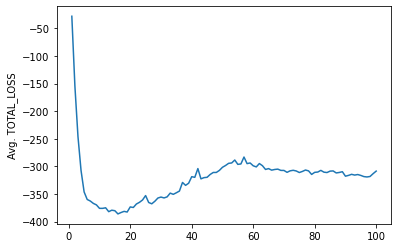

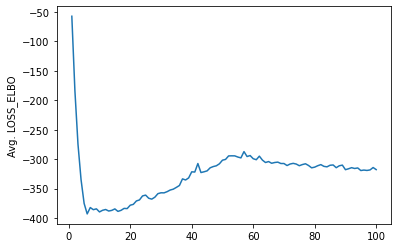

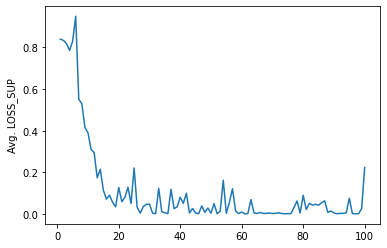

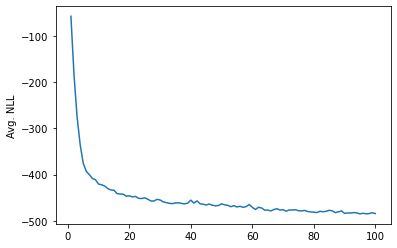

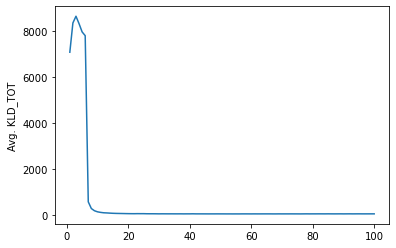

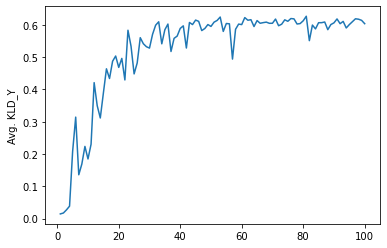

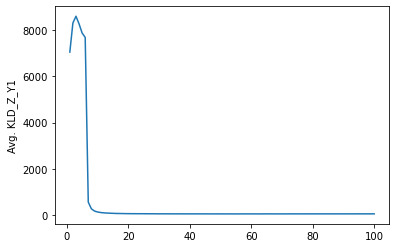

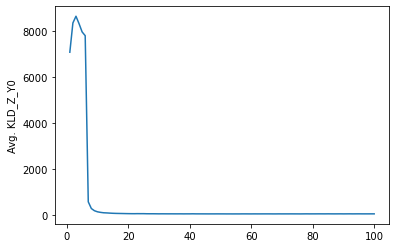

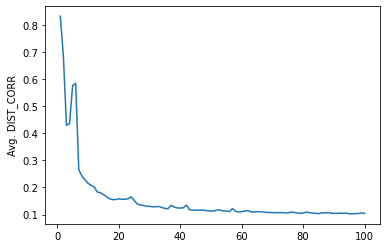

In [28]:
# Plots for losses
for col_name in df_train_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
        plt.show()

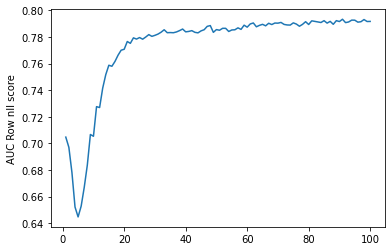

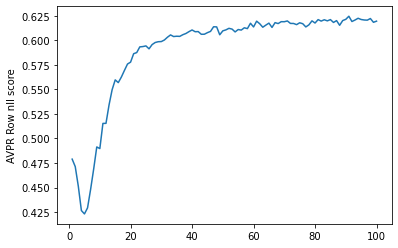

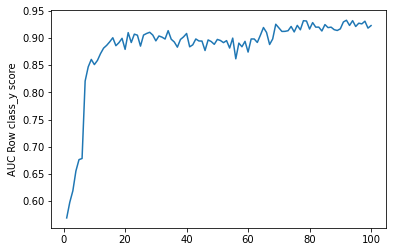

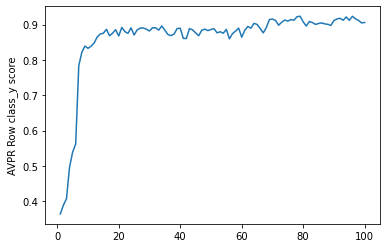

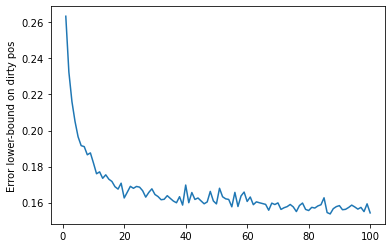

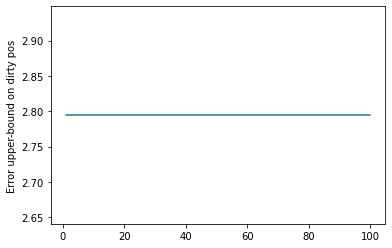

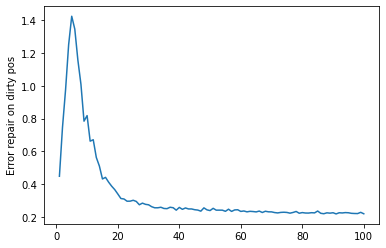

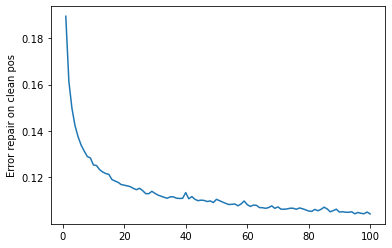

In [29]:
# Plots for classification and repair metrics
list_plot_custom = ["AUC Row nll score", "AVPR Row nll score", 
                    "AUC Row class_y score", "AVPR Row class_y score",
                    "Error lower-bound on dirty pos", "Error upper-bound on dirty pos",
                    "Error repair on dirty pos", "Error repair on clean pos"]

for col_name in list_plot_custom:
    sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
    plt.show()

## Plots Validation -- Losses

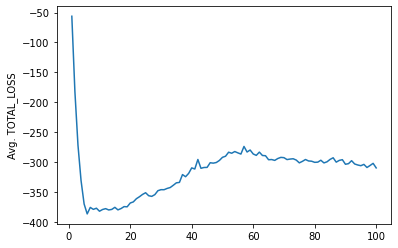

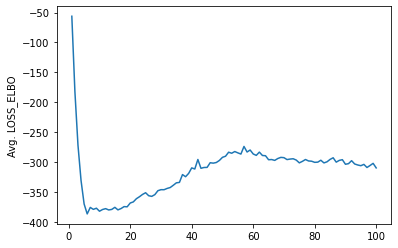

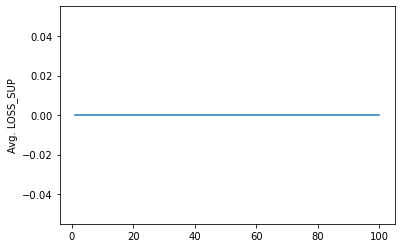

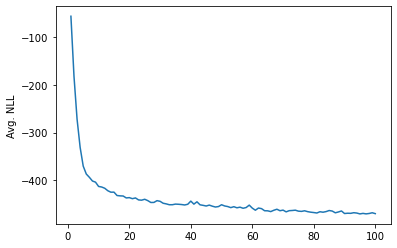

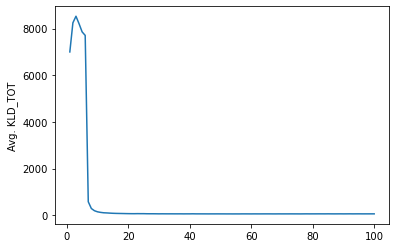

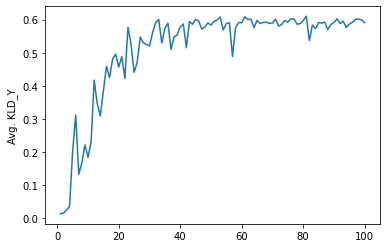

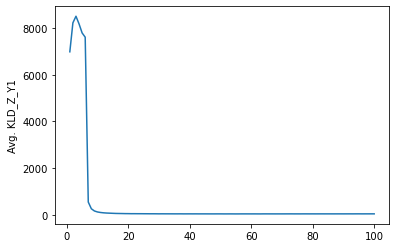

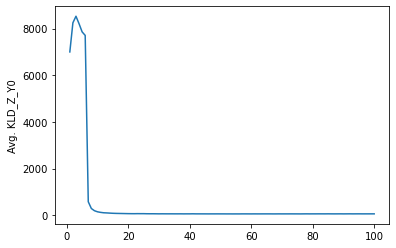

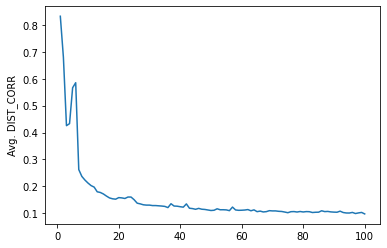

In [30]:
# Plots for losses
for col_name in df_valid_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_valid_metrics[col_name])
        plt.show()

### Plot Test -- Losses

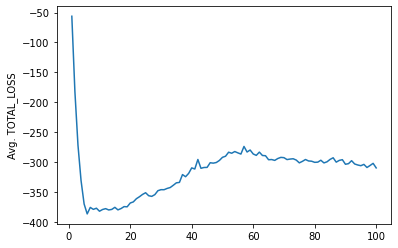

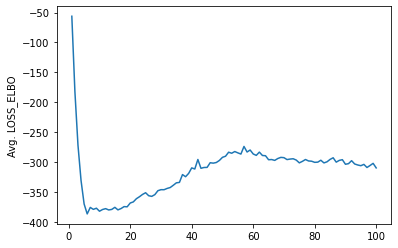

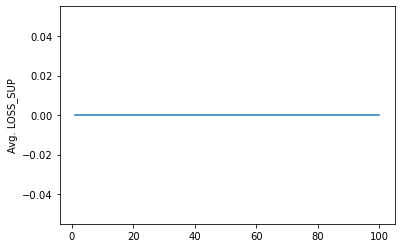

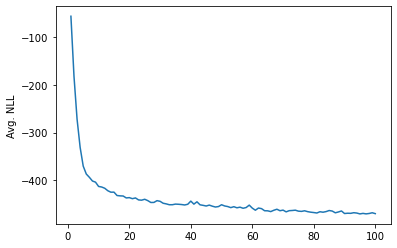

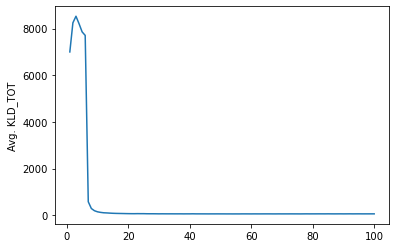

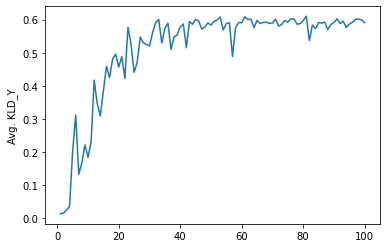

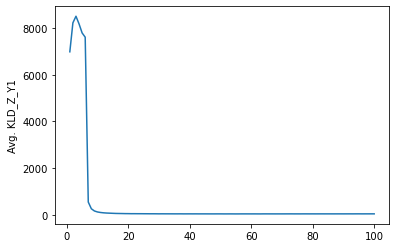

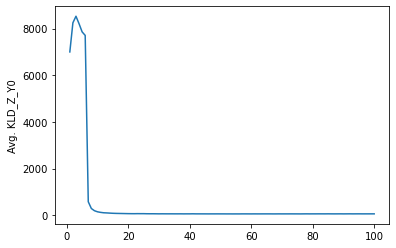

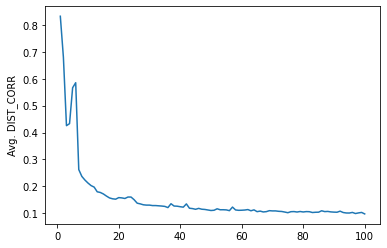

In [31]:
# Plots for losses
for col_name in df_test_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_test_metrics[col_name])
        plt.show()

### Get Recons, Latent Space, etc

In [32]:
vae_p_params_xd, vae_q_params, vae_q_samples, _ = vae_mdl(X_train)
recons_train = vae_p_params_xd['recon']['x'].cpu().detach().numpy()
z_train_clean = vae_q_params['z']['mu'].detach().cpu().numpy() # is z_y1 (clean)
z_train_dirty = vae_q_params['z_y0']['mu'].detach().cpu().numpy() # is z_y0 (dirty)


In [33]:
# Show recon logvar
#vae_p_params_xd['recon']['logvar_x'].exp()

In [34]:
# Plot mu's and covariance's

z_train_y1_mu = vae_q_params['z']['mu'].detach().cpu().numpy() # is z_y1 (clean)
z_train_y0_mu = vae_q_params['z_y0']['mu'].detach().cpu().numpy() # is z_y0 (dirty)

z_train_y1_var = np.exp(vae_q_params['z']['logvar'].detach().cpu().numpy()) # is z_y1 (clean)
z_train_y0_var = np.exp(vae_q_params['z_y0']['logvar'].detach().cpu().numpy()) # is z_y0 (dirty)

print("median of variances (per dim), clean: \n {} \n".format(np.median(z_train_y1_var, axis=0)))
print("median of variances (per dim), dirty: \n {} \n".format(np.median(z_train_y0_var, axis=0)))

print("median of means (per dim), clean: \n {} \n".format(np.median(z_train_y1_mu, axis=0)))
print("median of means (per dim), dirty: \n {} \n".format(np.median(z_train_y0_mu, axis=0)))

median of variances (per dim), clean: 
 [1.63731329e-05 4.29935062e-06 1.45538888e-05 9.39863276e-06
 6.52190010e-06 1.37108855e-05 1.87758633e-05 9.28835470e-06
 7.99376721e-06 8.30963927e-06 9.99999885e-03 9.99999885e-03
 9.99999885e-03 9.99999885e-03 9.99999885e-03] 

median of variances (per dim), dirty: 
 [1.63731329e-05 4.29935062e-06 1.45538888e-05 9.39863276e-06
 6.52190010e-06 1.37108855e-05 1.87758633e-05 9.28835470e-06
 7.99376721e-06 8.30963927e-06 2.65717171e-02 3.59199271e-02
 2.44132448e-02 3.49990316e-02 3.37264091e-02] 

median of means (per dim), clean: 
 [ 0.23905775 -0.05203929 -0.13176262 -0.12451386 -0.09026383  0.13409767
  0.30430663  0.00432508 -0.04663673  0.08473606  0.          0.
  0.          0.          0.        ] 

median of means (per dim), dirty: 
 [ 0.23905775 -0.05203929 -0.13176262 -0.12451386 -0.09026383  0.13409767
  0.30430663  0.00432508 -0.04663673  0.08473606  0.36674953  0.1272704
 -0.72252446  0.06560859  0.08234639] 



In [35]:
recon_imgs_train = recons_train.reshape(-1,28,28)*dataset_obj.cont_stds + dataset_obj.cont_means

### Show Clean Datapoints at Random

y_noise: 0


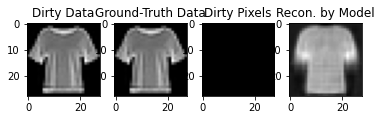

y_noise: 0


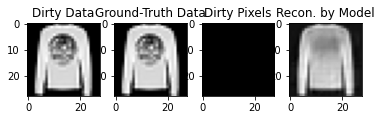

y_noise: 0


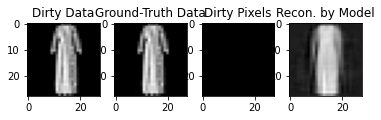

y_noise: 0


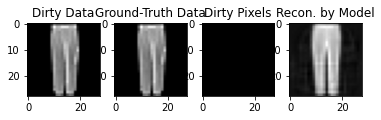

y_noise: 0


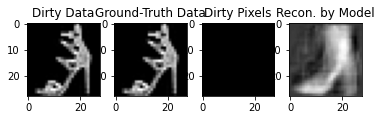

y_noise: 0


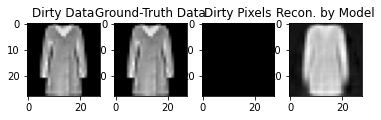

y_noise: 0


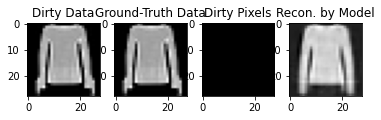

y_noise: 0


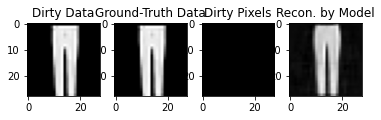

y_noise: 0


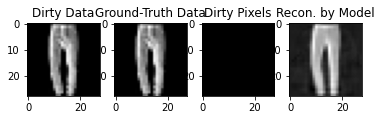

y_noise: 0


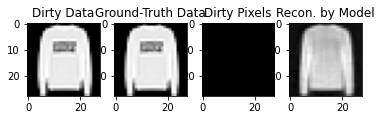

y_noise: 0


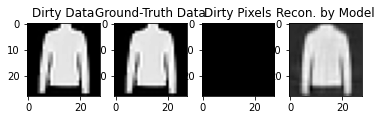

y_noise: 0


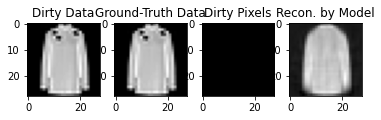

y_noise: 0


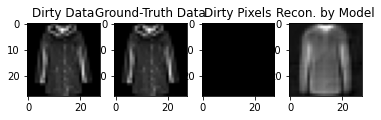

y_noise: 0


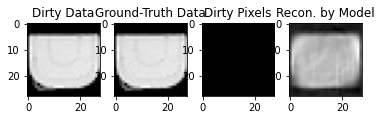

y_noise: 0


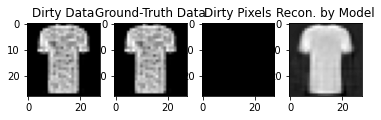

y_noise: 0


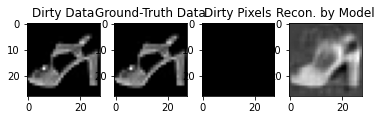

y_noise: 0


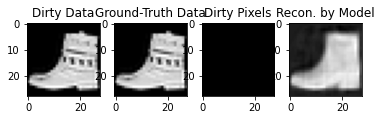

y_noise: 0


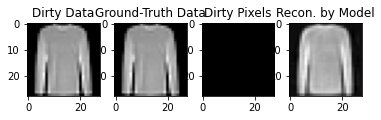

y_noise: 0


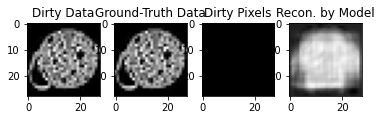

y_noise: 0


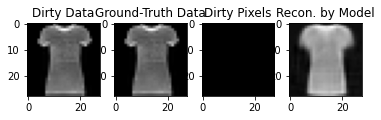

y_noise: 0


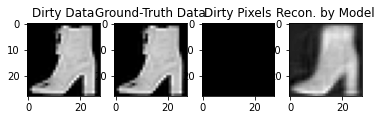

y_noise: 0


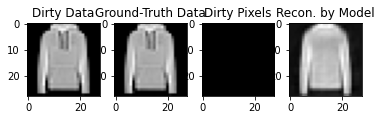

y_noise: 0


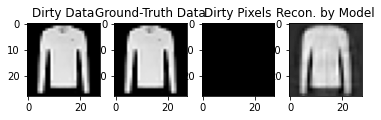

y_noise: 0


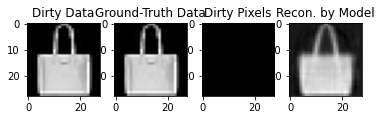

y_noise: 0


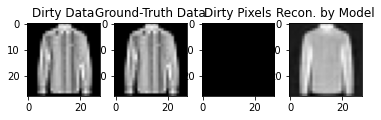

In [36]:
max_imgs_show = 25
y_noise_idxs_train = np.where(~y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()



### Show Dirty Datapoints at Random

y_noise: 1


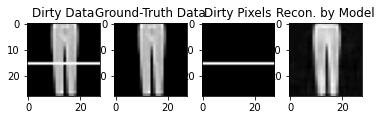

y_noise: 1


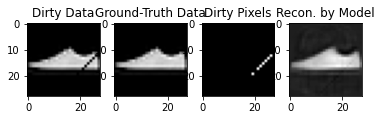

y_noise: 1


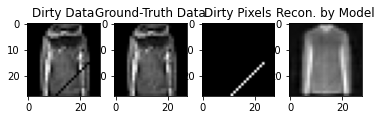

y_noise: 1


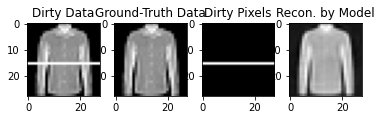

y_noise: 1


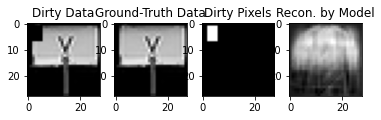

y_noise: 1


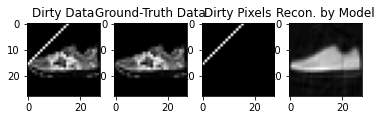

y_noise: 1


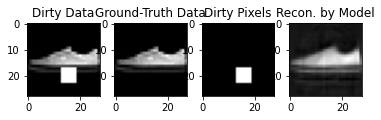

y_noise: 1


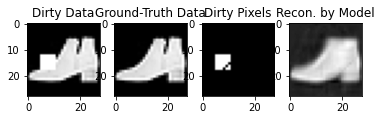

y_noise: 1


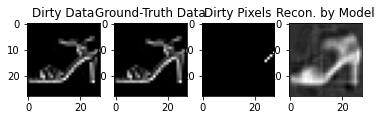

y_noise: 1


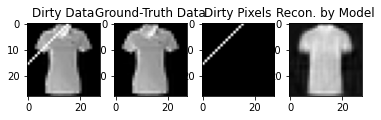

y_noise: 1


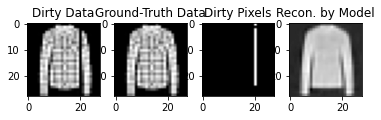

y_noise: 1


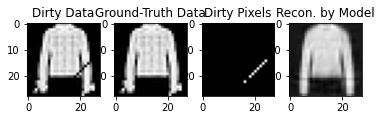

y_noise: 1


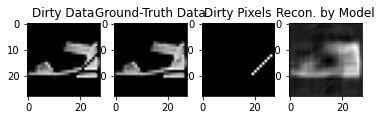

y_noise: 1


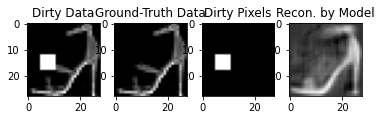

y_noise: 1


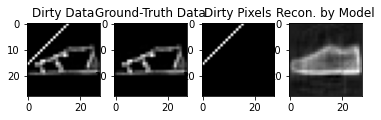

y_noise: 1


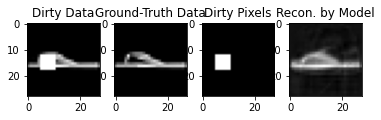

y_noise: 1


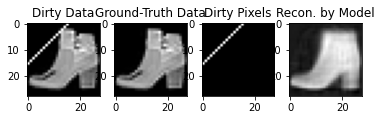

y_noise: 1


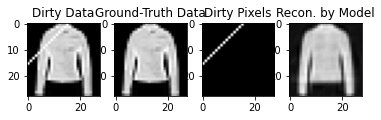

y_noise: 1


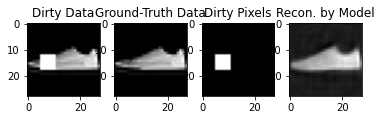

y_noise: 1


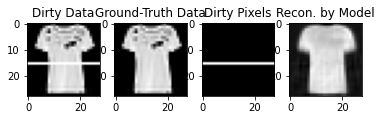

y_noise: 1


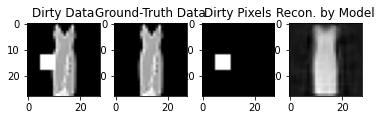

y_noise: 1


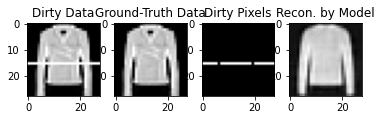

y_noise: 1


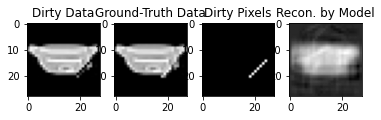

y_noise: 1


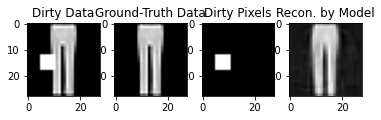

y_noise: 1


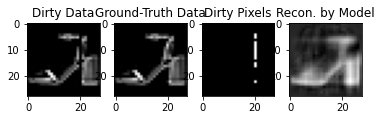

In [37]:
max_imgs_show = 25
y_noise_idxs_train = np.where(y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()



### Show per noise type images: y_noise_lists or y_noise_dict

Noise Tag: 0
Noise Indices: 
[49931, 9771, 2510, 33084, 41761, 7530, 38857, 53534, 21939, 14918, 39744, 15426, 32323, 20632, 7050, 4447, 45382, 43836, 889, 11720, 39865, 23198, 11298, 30709, 25732, 51560, 47193, 427, 49007, 30733, 329, 184, 50395, 16263, 15873, 8737, 9298, 20931, 8146, 14359, 29429, 24443, 8078, 5111, 42352, 40877, 34124, 11758, 16969, 35456, 33512, 17311, 31692, 29687, 18192, 354, 14346, 18371, 29243, 5827, 22187, 33753, 22468, 825, 36417, 25156, 6677, 11892, 39455, 28598, 28866, 29012, 49705, 18478, 17475, 29010, 46510, 52853, 3951, 32273, 51429, 38786, 18792, 45433, 41177, 38580, 41392, 43421, 1829, 10511, 46151, 23010, 32478, 40374, 44815, 15102, 33016, 14001, 48481, 14646, 1842, 27806, 24926, 44427, 50380, 21210, 11946, 44239, 47652, 24080, 12759, 17001, 28553, 24581, 45890, 43155, 29797, 18559, 5625, 24354, 50551, 10438, 8258, 18819, 275, 17584, 43356, 51916, 18405, 48138, 30938, 53837, 42044, 14145, 29088, 12916, 49020, 19994, 23257, 1813, 16677, 51223, 39860, 4

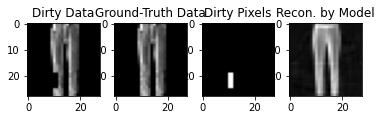

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


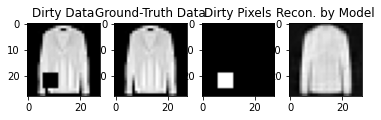

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


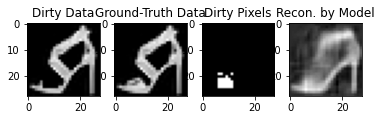

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


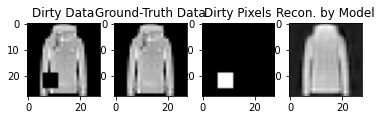

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


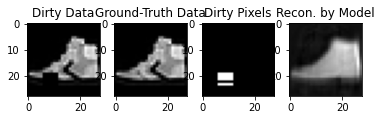

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


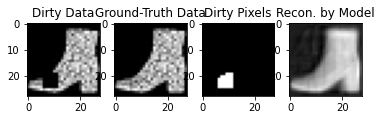

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


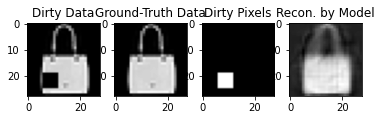

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


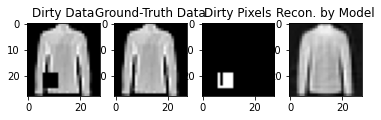

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


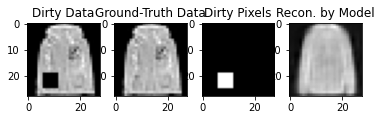

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


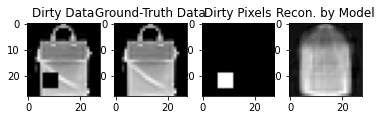







Noise Tag: 1
Noise Indices: 
[2268, 27023, 39295, 17345, 23381, 6724, 21779, 49332, 37763, 12352, 25490, 41004, 12120, 6851, 41191, 52734, 44138, 21195, 4012, 50839, 26136, 27191, 47045, 32952, 32785, 33875, 180, 24843, 24830, 35419, 7378, 1449, 39752, 48949, 20210, 44486, 35491, 42932, 19214, 13789, 40058, 8047, 42606, 47808, 47673, 24398, 11586, 44102, 20568, 1178, 8153, 37296, 29438, 14731, 39789, 17290, 20623, 20929, 7169, 13747, 16563, 4010, 42029, 50463, 47743, 5627, 1226, 42234, 46227, 22186, 18626, 34349, 14634, 4621, 13437, 8454, 9712, 49154, 34317, 53145, 49726, 37859, 33263, 34665, 40696, 41405, 11476, 45200, 7882, 37604, 34107, 35467, 46351, 5691, 7024, 27817, 18010, 34990, 25649, 2467, 7496, 48471, 21818, 43230, 50845, 44807, 14064, 23710, 29736, 10954, 27924, 37189, 17806, 37304, 17359, 31668, 49679, 20145, 8828, 27718, 5125, 9530, 12210, 32245, 17811, 12839, 41861, 21972, 22912, 25390, 2701, 43408, 51433, 48214, 44325, 49314, 22992, 23018, 36675, 12335, 7484, 7078,

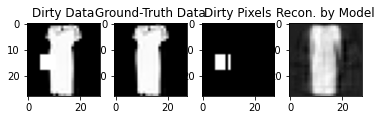

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


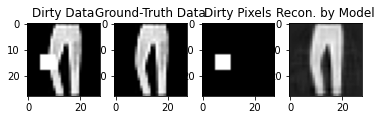

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


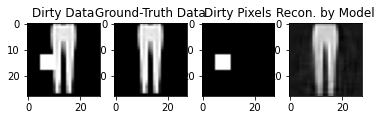

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


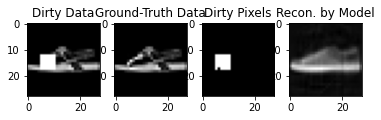

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


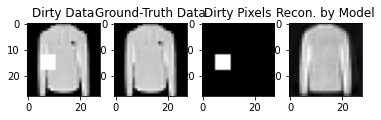

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


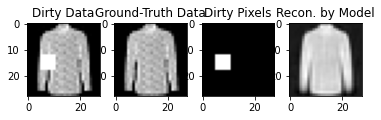

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


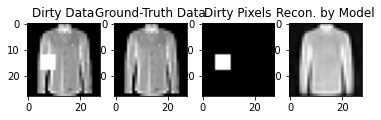

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


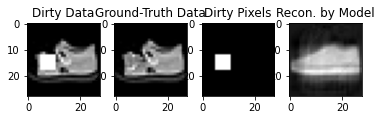

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


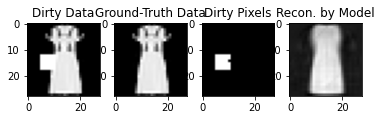

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


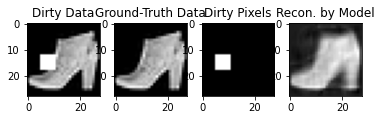







Noise Tag: 2
Noise Indices: 
[52779, 17788, 34554, 13623, 10531, 13700, 33584, 52448, 45317, 20115, 9326, 35823, 34557, 5426, 6829, 44986, 33693, 25305, 40581, 16629, 16001, 48505, 25911, 9510, 5268, 21970, 24585, 32050, 43151, 22268, 36353, 8949, 6303, 48762, 34382, 16466, 18890, 21839, 24773, 17496, 49823, 9462, 41420, 27798, 23594, 44911, 16838, 48332, 33951, 14218, 20845, 42306, 40390, 38054, 48068, 12499, 1548, 45174, 4040, 23881, 43826, 50418, 28417, 27913, 21362, 25921, 11775, 18170, 42183, 3415, 2611, 46995, 24266, 37984, 41214, 20917, 19490, 29409, 31751, 42060, 28040, 42123, 29576, 7119, 27383, 51591, 16515, 14063, 28379, 8023, 25618, 39199, 35583, 6326, 15419, 2340, 49177, 13897, 48046, 8501, 50772, 20143, 37360, 30964, 17317, 27474, 4111, 12250, 42540, 14790, 15091, 38929, 31914, 50222, 31321, 49903, 29467, 41790, 23972, 53082, 27071, 27897, 38879, 26217, 15853, 34636, 5430, 33746, 39250, 13322, 36011, 5819, 8590, 42478, 17616, 14345, 32335, 12681, 32986, 34195, 18549

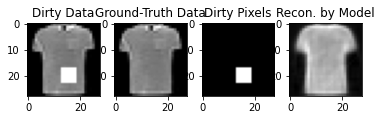

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


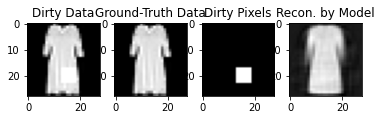

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


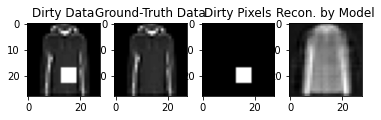

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


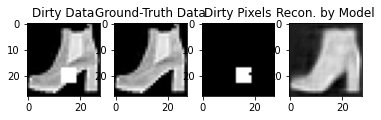

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


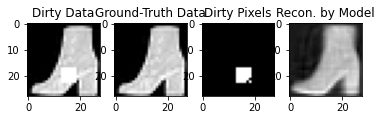

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


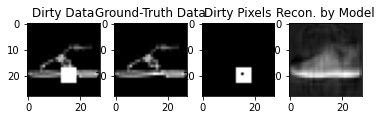

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


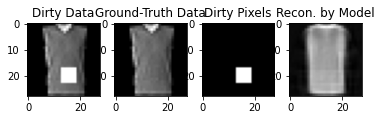

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


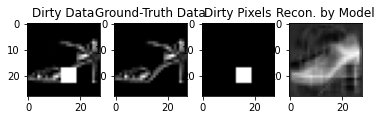

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


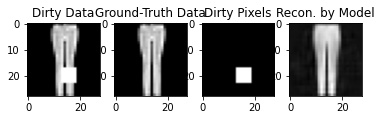

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


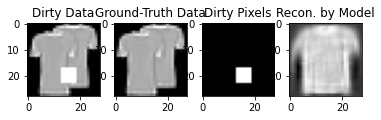







Noise Tag: 3
Noise Indices: 
[5853, 11247, 42551, 7181, 16971, 50044, 51782, 14722, 29140, 37744, 25137, 53907, 10840, 14324, 16757, 53262, 41469, 17974, 15416, 24707, 37293, 38816, 10987, 22127, 2641, 49496, 15671, 46066, 19139, 41891, 28160, 25336, 46399, 42703, 45763, 5178, 3483, 20680, 18845, 47719, 28075, 19678, 36318, 32345, 52609, 11071, 10666, 3146, 27766, 33779, 50527, 41442, 32319, 11920, 49201, 13393, 32048, 2091, 25676, 15667, 33091, 34035, 44390, 11182, 41226, 48094, 6797, 22581, 31176, 15013, 46307, 43893, 46453, 19705, 24350, 50379, 17524, 31972, 42550, 27037, 40082, 10809, 33896, 36274, 43520, 2846, 20520, 52770, 87, 26287, 22785, 30434, 16825, 48967, 24420, 6168, 46186, 37347, 45750, 48761, 49970, 41902, 34316, 3986, 52396, 19508, 37782, 45893, 34641, 33108, 32615, 30878, 8517, 28092, 3382, 43271, 3782, 2159, 12477, 51915, 5820, 25592, 32593, 8429, 25471, 33774, 47607, 25334, 283, 46247, 22726, 8026, 43521, 31427, 8226, 28153, 44405, 29219, 25611, 50983, 11965, 4

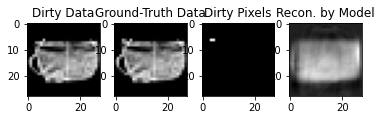

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


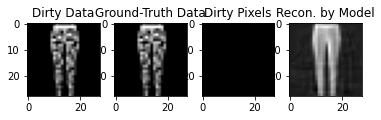

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


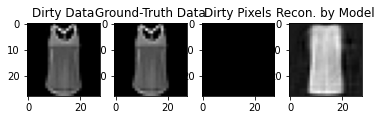

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


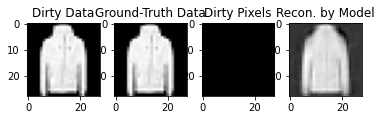

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


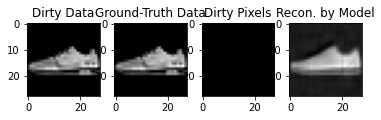

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


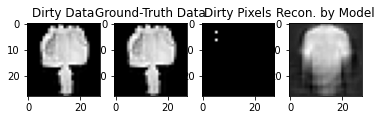

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


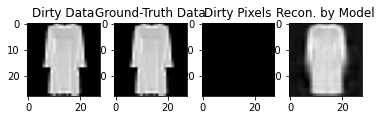

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


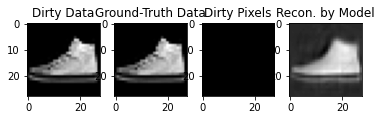

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 3


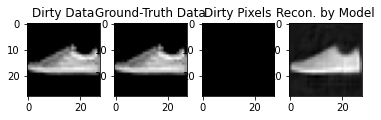

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


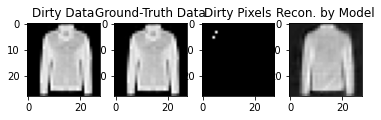







Noise Tag: 4
Noise Indices: 
[48575, 31148, 48450, 33830, 7987, 10979, 1890, 18322, 19790, 45950, 7745, 3091, 23937, 53797, 25488, 44933, 51698, 48005, 17100, 1365, 19039, 4002, 37067, 17886, 32907, 43312, 51657, 6153, 3318, 42061, 22969, 9812, 8061, 1077, 27400, 35271, 39484, 24516, 30069, 45491, 46324, 18508, 12583, 9978, 21282, 44903, 17853, 41611, 23748, 2369, 27320, 38491, 46181, 47549, 11944, 39121, 47470, 4845, 6150, 22136, 20136, 7640, 19879, 36558, 30010, 11538, 23295, 43274, 12090, 35806, 36044, 28327, 30707, 52095, 9025, 13832, 14662, 53234, 23949, 51981, 37775, 48746, 8821, 23859, 32559, 1272, 24058, 4869, 6784, 35433, 31126, 7079, 51871, 32266, 6666, 22040, 44831, 25763, 17982, 29302, 15324, 51808, 4417, 45326, 14601, 35863, 30904, 5610, 47043, 53370, 35717, 16154, 41557, 14105, 37807, 37335, 2009, 15439, 30029, 41156, 4303, 41094, 22388, 12831, 8792, 43175, 35699, 5881, 45136, 22659, 30368, 43694, 11220, 13492, 43669, 6849, 46615, 51712, 3833, 22157, 18750, 19896, 2

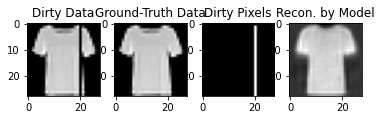

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


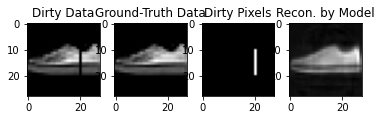

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


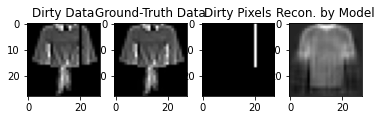

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


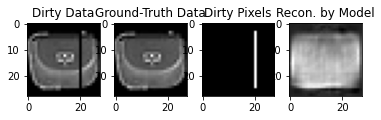

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


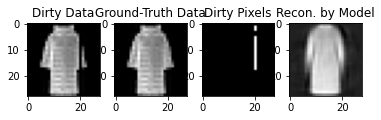

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


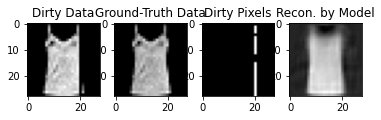

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


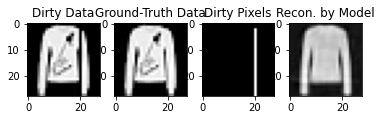

y_class (clean): 0 | y_noise: False | y_noise_tag (noise type): 4


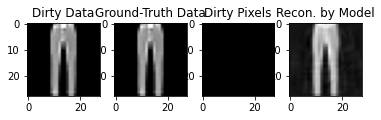

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


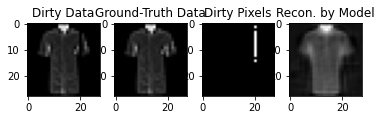

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 4


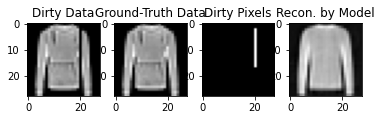







Noise Tag: 5
Noise Indices: 
[41366, 35857, 21758, 42930, 12425, 8919, 20074, 21360, 50284, 28505, 15387, 39772, 36500, 27442, 25985, 34272, 53223, 47175, 49465, 34404, 13910, 10124, 31626, 10920, 21897, 45556, 48088, 927, 43309, 27611, 16062, 4233, 20249, 25116, 36367, 11843, 3978, 4677, 22660, 43990, 31854, 34732, 53976, 3017, 1199, 49324, 44998, 27176, 11041, 18810, 29453, 34407, 4060, 17860, 20989, 15437, 10472, 2443, 9296, 13823, 17272, 24867, 10225, 27133, 32026, 17337, 35463, 34341, 41976, 29866, 35635, 24225, 14893, 45092, 47172, 347, 26071, 9039, 9220, 45828, 52221, 34739, 44667, 3012, 9371, 5393, 18051, 11131, 53536, 17752, 12194, 13315, 19093, 36948, 1780, 49077, 2266, 9322, 5217, 48240, 16182, 17219, 20798, 31912, 48181, 9518, 3780, 2652, 9397, 10342, 23460, 12787, 9150, 45606, 18477, 21612, 2721, 42149, 47290, 21396, 24486, 38086, 39885, 6469, 41985, 17023, 7632, 45420, 3602, 7466, 11383, 50371, 36845, 49424, 17898, 41024, 53137, 43949, 30608, 51186, 29372, 37628, 98

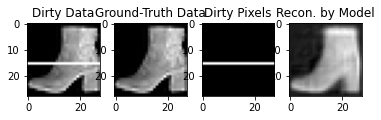

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


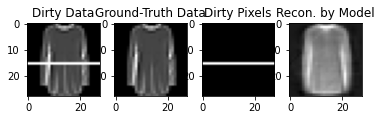

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


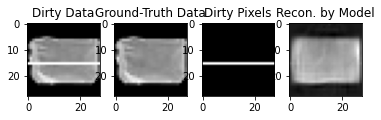

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


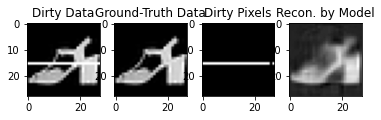

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


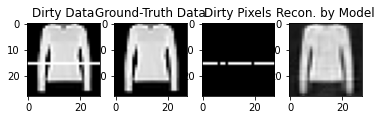

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


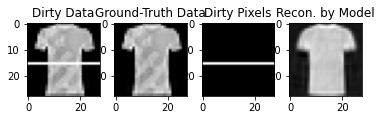

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


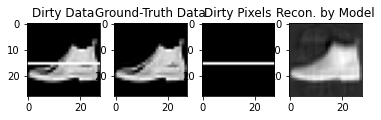

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


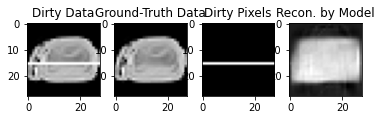

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


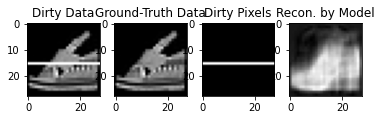

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 5


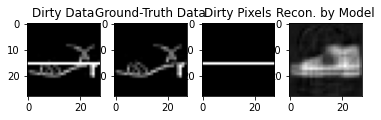







Noise Tag: 6
Noise Indices: 
[7450, 18091, 53161, 49480, 23297, 20825, 49950, 46922, 31791, 47239, 2759, 29933, 3967, 27056, 21588, 45917, 35274, 28391, 21857, 29897, 36213, 6516, 176, 35957, 31686, 6767, 35148, 34819, 49806, 7968, 32919, 10499, 53674, 11399, 46287, 8599, 1729, 26381, 47936, 19166, 14568, 49535, 26586, 34736, 32886, 37672, 13489, 44418, 19345, 24421, 36282, 33142, 3854, 10495, 36854, 44158, 19598, 621, 36704, 43908, 48847, 823, 48437, 43716, 49681, 37730, 52382, 12448, 35422, 24209, 50860, 29120, 14162, 44408, 49481, 23573, 24712, 26799, 37463, 24717, 24821, 52078, 33064, 21141, 6801, 36890, 36035, 4969, 45019, 41325, 39141, 23507, 29859, 42837, 7630, 26319, 44862, 13728, 42802, 41813, 4038, 30978, 33337, 8563, 8976, 1406, 53428, 14458, 38137, 52549, 16744, 50805, 53725, 49838, 41342, 15843, 4019, 23533, 5488, 14925, 19596, 23903, 29812, 1516, 22518, 45516, 11517, 1356, 8787, 8262, 47513, 20215, 27697, 44719, 2471, 12564, 16003, 53466, 18288, 11959, 41042, 7215, 

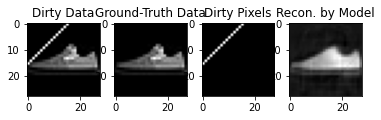

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


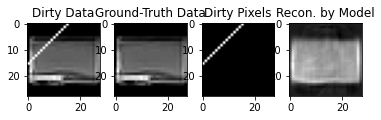

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


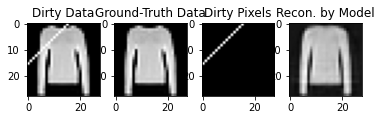

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


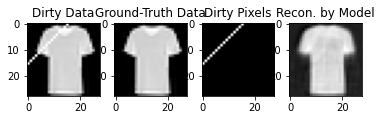

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


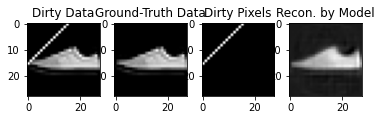

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


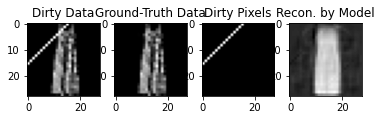

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


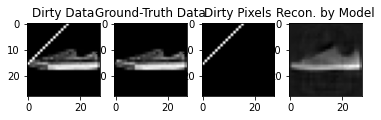

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


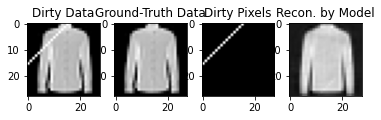

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


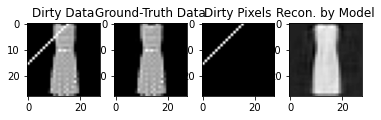

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 6


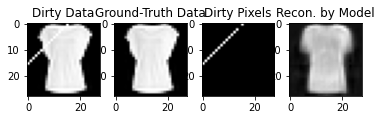







Noise Tag: 7
Noise Indices: 
[24116, 1936, 30892, 436, 45639, 12774, 7036, 15748, 42345, 33410, 6895, 30732, 44321, 32808, 4941, 3345, 41802, 19475, 31290, 1214, 7779, 42162, 12423, 9815, 40017, 48751, 52087, 15935, 52165, 44593, 22784, 39842, 19136, 28107, 11035, 19283, 38796, 5210, 33783, 13330, 43729, 44077, 32772, 46487, 22866, 37235, 46813, 31233, 24933, 36083, 24674, 11357, 19472, 22532, 9783, 3935, 23688, 1962, 16373, 44872, 28605, 48475, 19844, 18389, 33815, 31561, 52914, 41207, 32861, 52985, 49168, 50930, 26936, 37179, 51109, 12670, 7236, 37932, 30604, 42300, 31331, 53210, 45128, 44003, 10767, 1135, 43785, 45199, 45450, 30053, 9551, 31890, 38569, 42981, 12302, 36436, 11922, 26980, 36273, 33525, 44014, 20494, 5607, 22666, 52979, 3543, 49510, 44165, 33109, 31596, 40989, 43148, 26160, 26950, 10551, 11271, 42268, 25520, 2275, 27541, 2255, 52100, 37045, 46475, 17222, 10502, 11094, 5412, 8347, 46890, 30175, 19604, 42317, 24251, 28590, 38278, 22985, 25298, 31439, 5236, 15862, 2

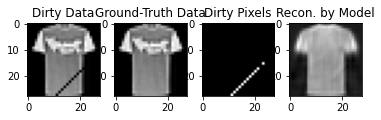

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


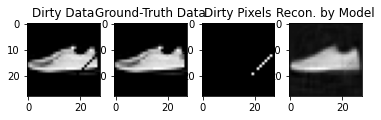

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


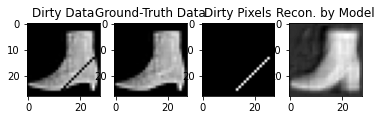

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


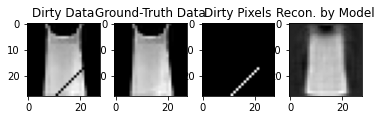

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


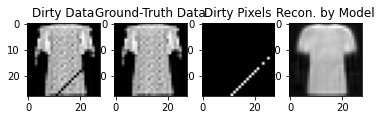

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


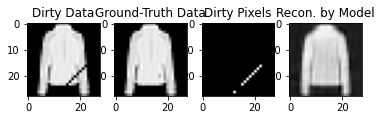

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


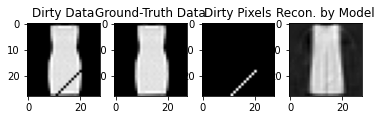

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


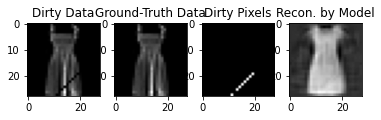

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


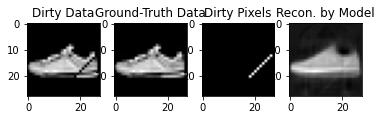

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 7


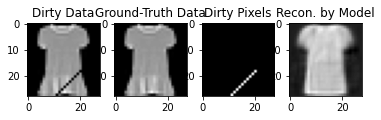

In [38]:
## show per noise type images: y_noise_lists or y_noise_dict

max_show_n = 10

for noise_key, noise_idxs in y_noise_dict_train.items():
    
    print("Noise Tag: {}".format(noise_key))
    print("Noise Indices: \n{}".format(noise_idxs))
    
    _selected_idxs = np.random.permutation(noise_idxs)[:max_show_n]
    
    for idx in _selected_idxs:
    
        print("y_class (clean): {} | y_noise: {} | y_noise_tag (noise type): {}".format(
            0, y_noise_instance_train[idx], noise_key)) # y_class_train[idx]
        fig, ax = plt.subplots(1,4)
        ax[0].imshow(x_train_orig[idx,...],cmap="gray")
        ax[0].set_title("Dirty Data")
        ax[1].imshow(x_train_clean_orig[idx,...],cmap="gray")
        ax[1].set_title("Ground-Truth Data")
        ax[2].imshow(y_noise_pixels_train[idx,...],cmap="gray")
        ax[2].set_title("Dirty Pixels")
        #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].set_title("Recon. by Model")
        plt.show()
        
    print("\n\n\n\n\n")


### Show Trusted Set (Clean Ground-Truth, Train Data, Recon)

In [39]:
len(trusted_idxs_train)

180

y_noise: 0


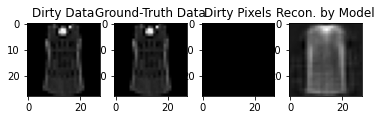

y_noise: 0


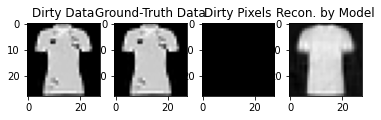

y_noise: 0


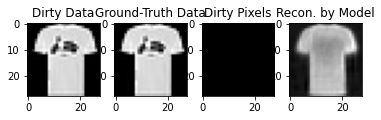

y_noise: 0


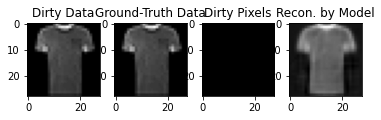

y_noise: 0


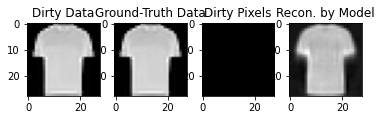

y_noise: 0


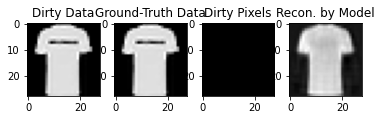

y_noise: 0


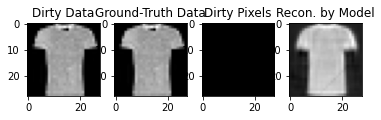

y_noise: 0


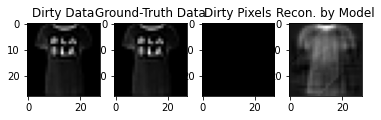

y_noise: 0


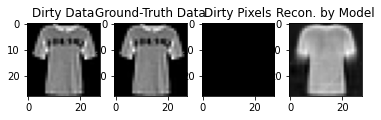

y_noise: 0


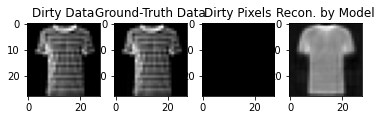

y_noise: 0


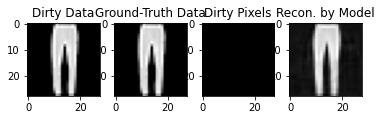

y_noise: 0


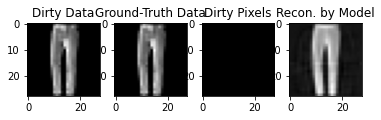

y_noise: 0


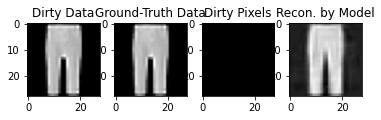

y_noise: 0


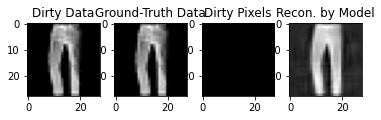

y_noise: 0


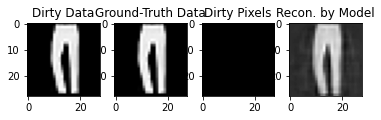

y_noise: 0


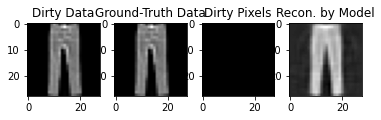

y_noise: 0


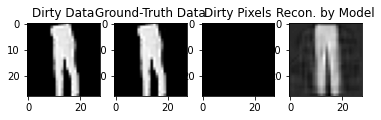

y_noise: 0


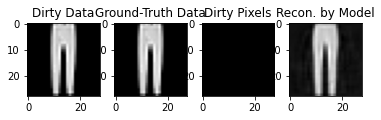

y_noise: 0


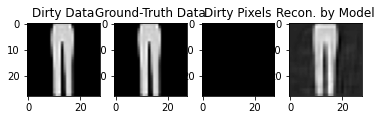

y_noise: 0


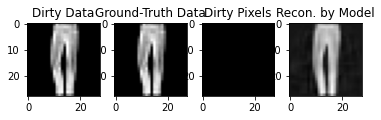

y_noise: 0


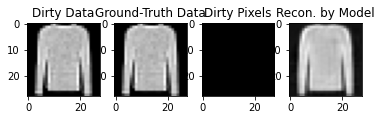

y_noise: 0


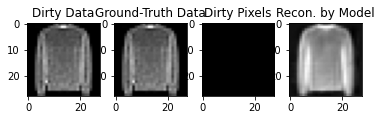

y_noise: 0


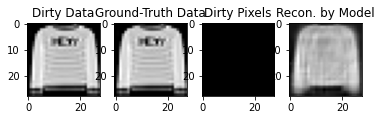

y_noise: 0


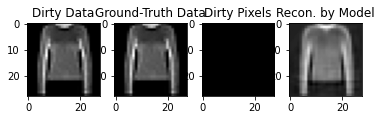

y_noise: 0


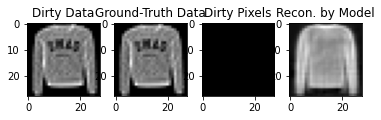

y_noise: 0


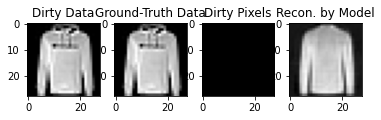

y_noise: 0


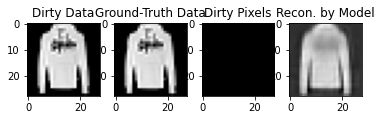

y_noise: 0


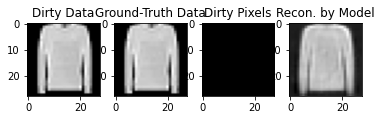

y_noise: 0


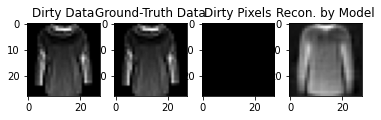

y_noise: 0


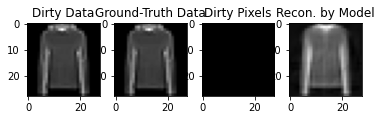

y_noise: 0


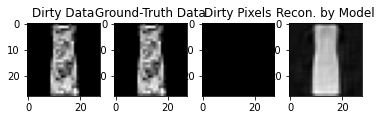

y_noise: 0


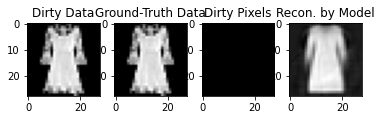

y_noise: 0


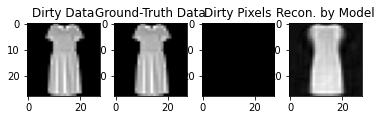

y_noise: 0


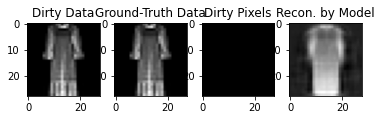

y_noise: 0


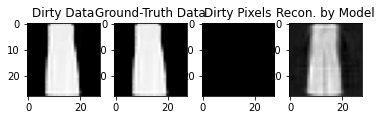

y_noise: 0


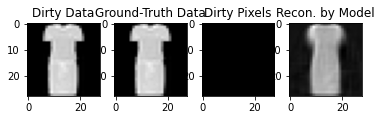

y_noise: 0


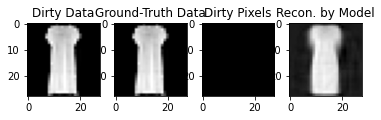

y_noise: 0


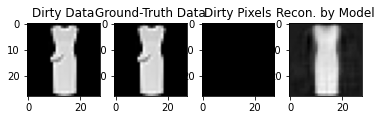

y_noise: 0


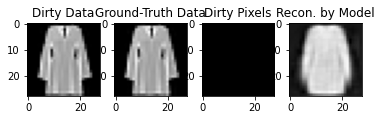

y_noise: 0


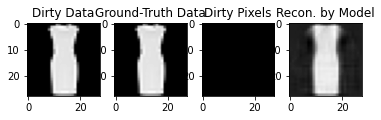

y_noise: 0


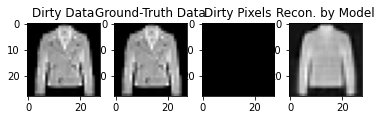

y_noise: 0


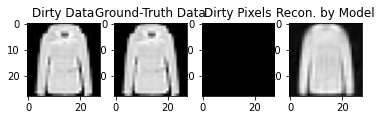

y_noise: 0


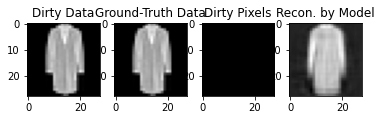

y_noise: 0


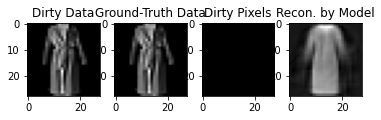

y_noise: 0


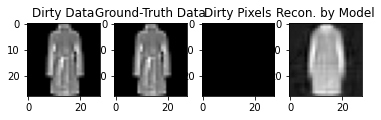

y_noise: 0


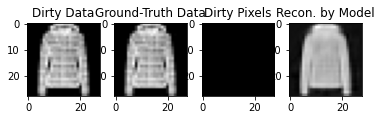

y_noise: 0


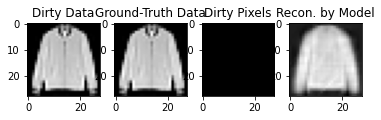

y_noise: 0


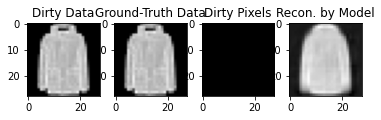

y_noise: 0


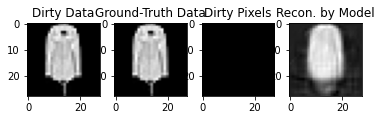

y_noise: 0


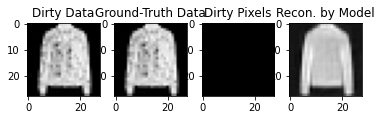

y_noise: 0


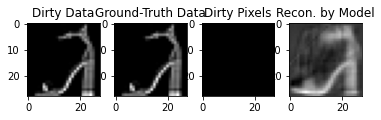

y_noise: 0


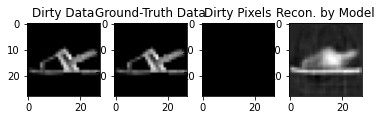

y_noise: 0


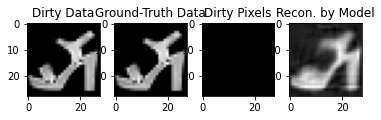

y_noise: 0


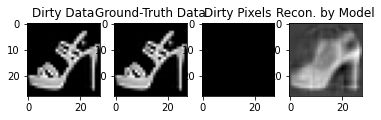

y_noise: 0


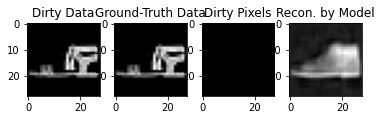

y_noise: 0


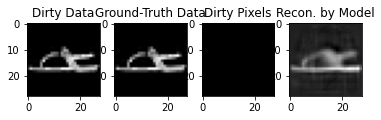

y_noise: 0


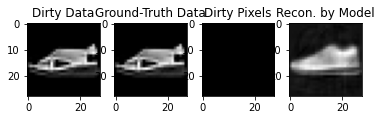

y_noise: 0


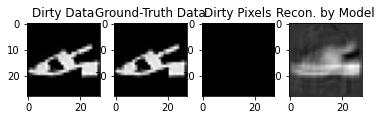

y_noise: 0


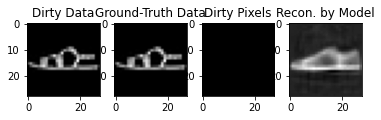

y_noise: 0


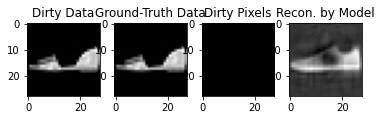

y_noise: 0


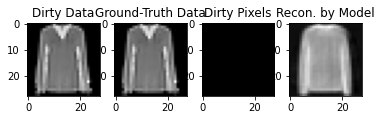

y_noise: 0


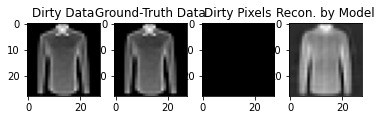

y_noise: 0


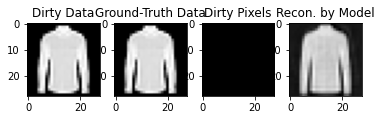

y_noise: 0


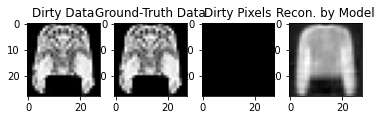

y_noise: 0


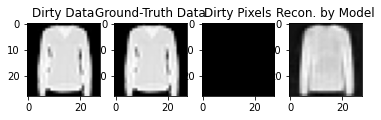

y_noise: 0


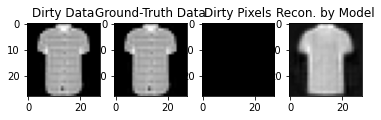

y_noise: 0


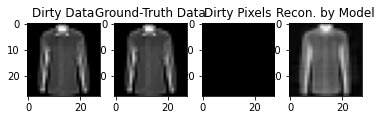

y_noise: 0


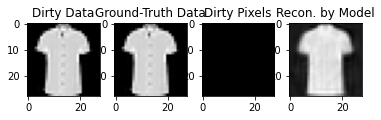

y_noise: 0


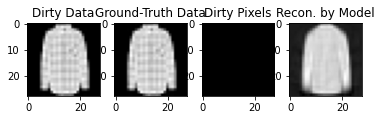

y_noise: 0


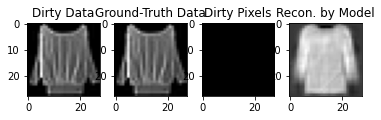

y_noise: 0


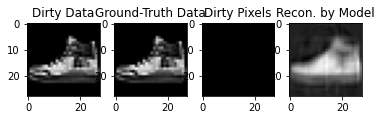

y_noise: 0


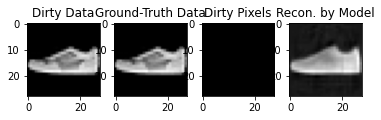

y_noise: 0


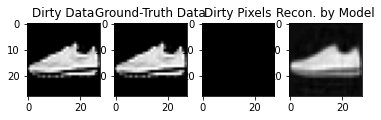

y_noise: 0


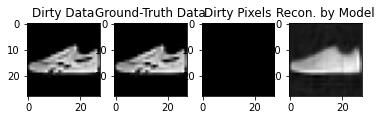

y_noise: 0


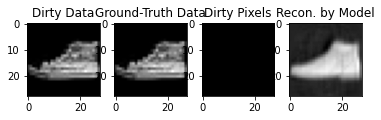

y_noise: 0


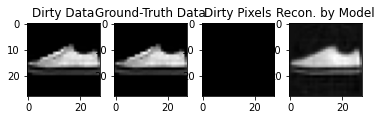

y_noise: 0


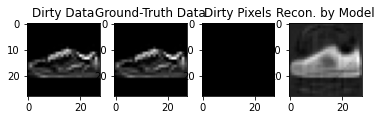

y_noise: 0


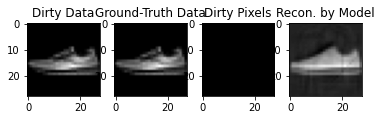

y_noise: 0


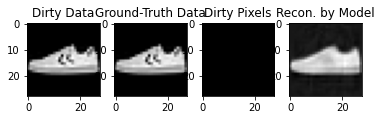

y_noise: 0


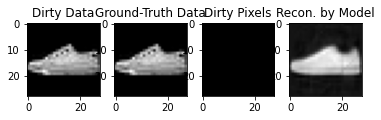

y_noise: 0


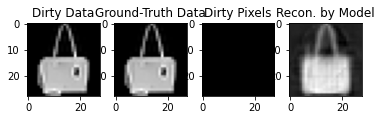

y_noise: 0


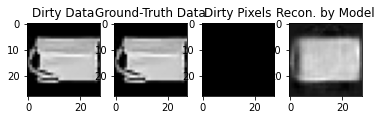

y_noise: 0


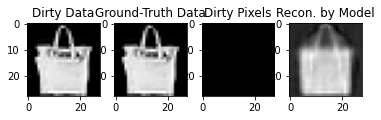

y_noise: 0


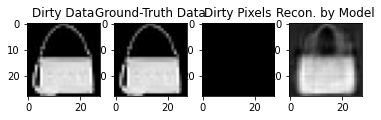

y_noise: 0


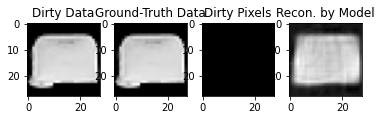

y_noise: 0


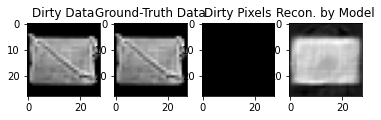

y_noise: 0


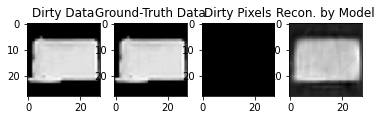

y_noise: 0


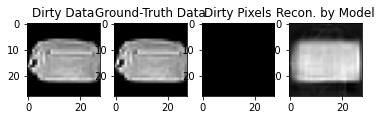

y_noise: 0


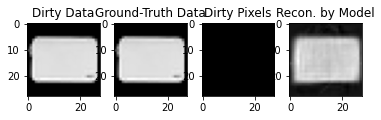

y_noise: 0


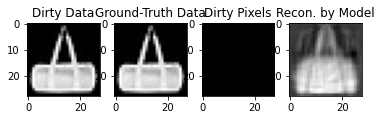

y_noise: 0


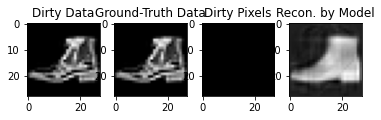

y_noise: 0


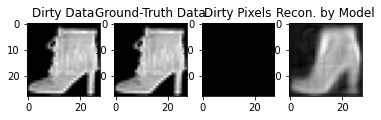

y_noise: 0


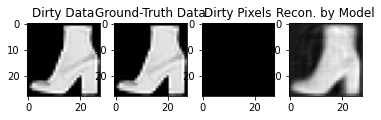

y_noise: 0


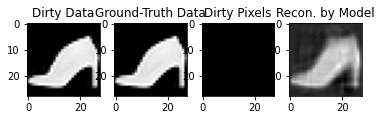

y_noise: 0


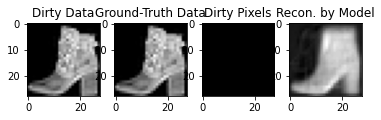

y_noise: 0


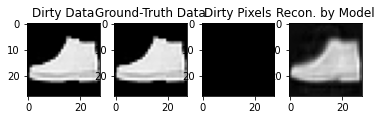

y_noise: 0


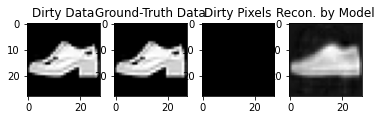

y_noise: 0


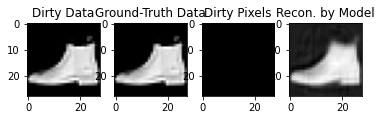

y_noise: 0


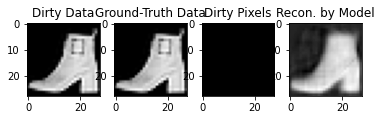

y_noise: 0


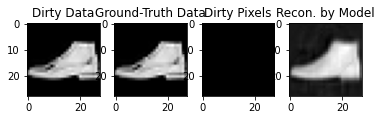

y_noise: 1


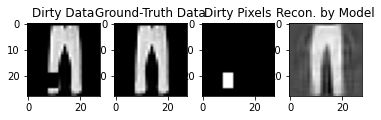

y_noise: 1


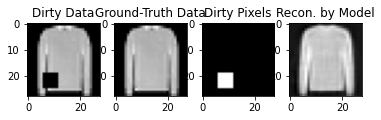

y_noise: 1


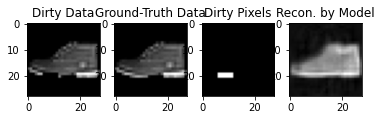

y_noise: 1


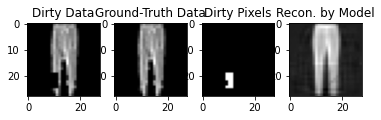

y_noise: 1


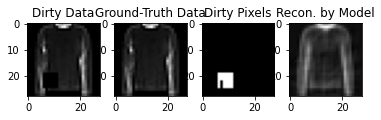

y_noise: 1


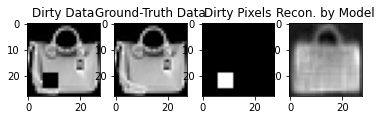

y_noise: 1


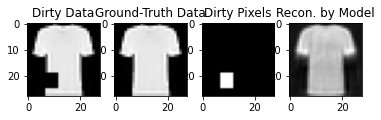

y_noise: 1


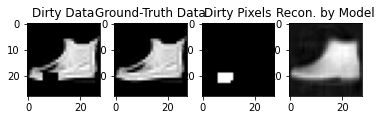

y_noise: 1


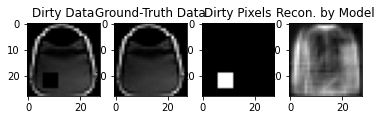

y_noise: 1


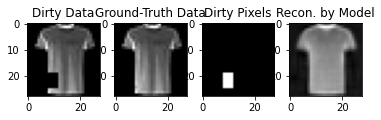

y_noise: 1


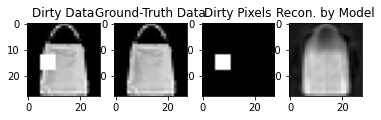

y_noise: 1


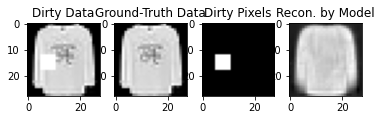

y_noise: 1


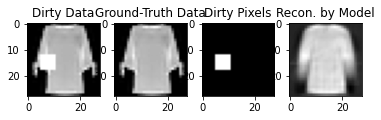

y_noise: 1


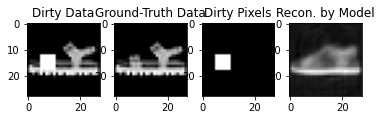

y_noise: 1


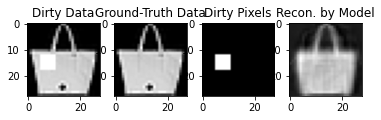

y_noise: 1


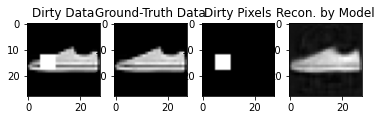

y_noise: 1


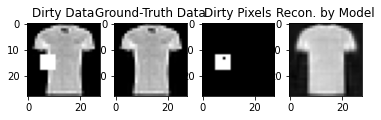

y_noise: 1


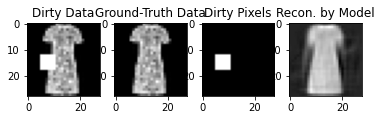

y_noise: 1


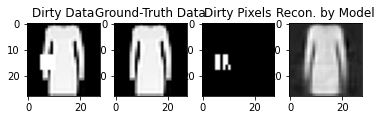

y_noise: 1


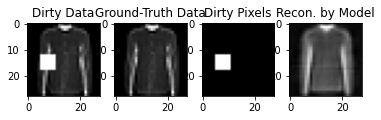

y_noise: 1


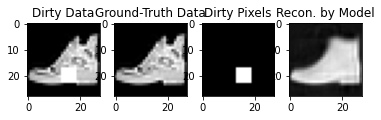

y_noise: 1


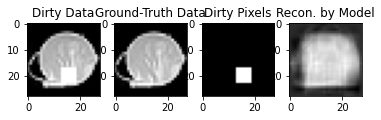

y_noise: 1


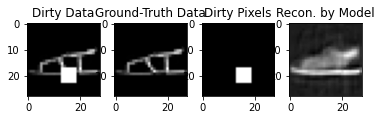

y_noise: 1


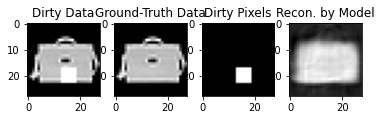

y_noise: 1


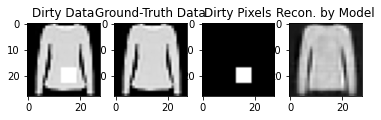

y_noise: 1


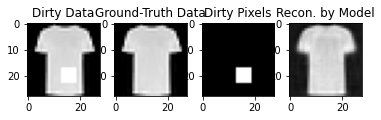

y_noise: 1


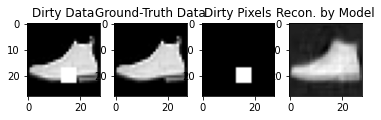

y_noise: 1


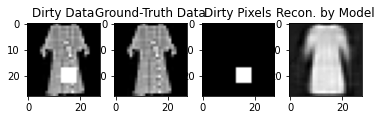

y_noise: 1


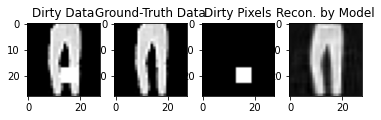

y_noise: 1


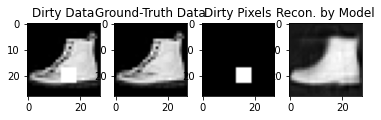

y_noise: 0


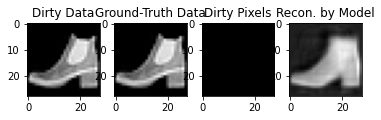

y_noise: 0


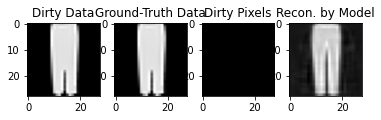

y_noise: 1


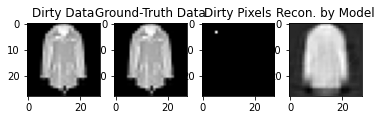

y_noise: 0


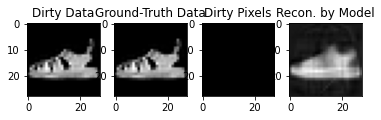

y_noise: 1


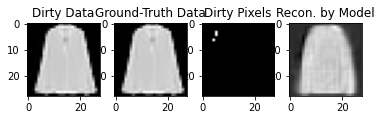

y_noise: 0


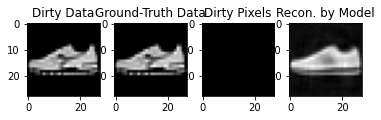

y_noise: 0


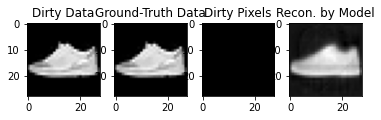

y_noise: 0


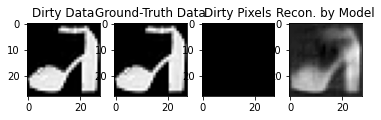

y_noise: 0


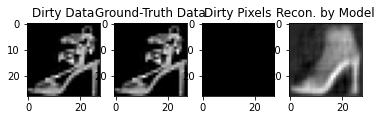

y_noise: 0


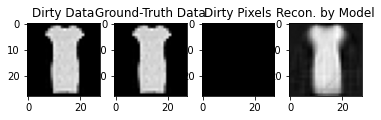

y_noise: 0


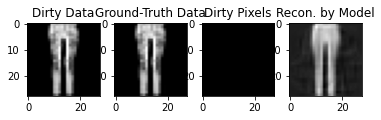

y_noise: 1


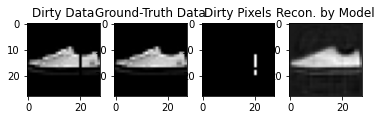

y_noise: 1


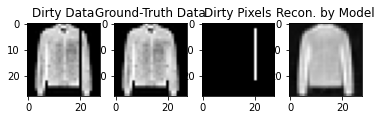

y_noise: 1


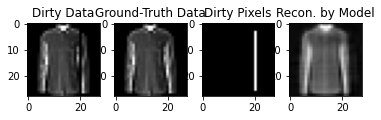

y_noise: 1


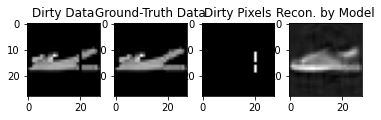

y_noise: 1


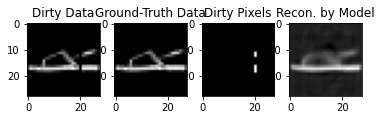

y_noise: 1


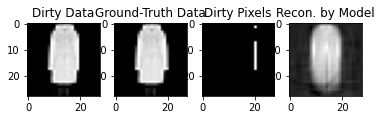

y_noise: 1


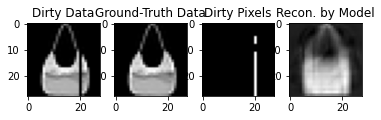

y_noise: 1


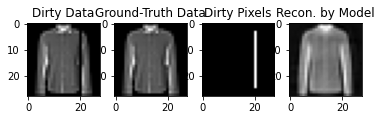

y_noise: 1


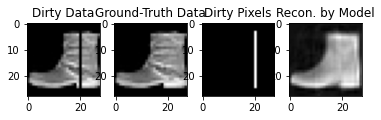

y_noise: 1


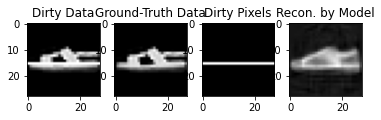

y_noise: 1


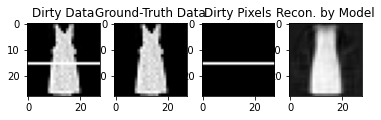

y_noise: 1


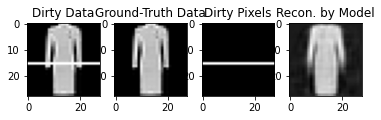

y_noise: 1


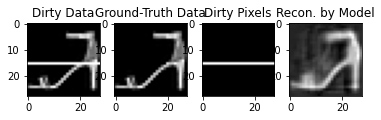

y_noise: 1


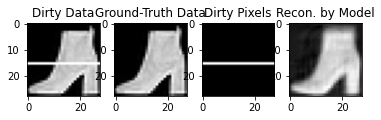

y_noise: 1


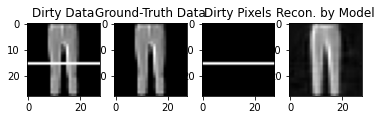

y_noise: 1


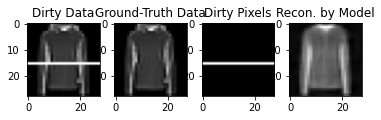

y_noise: 1


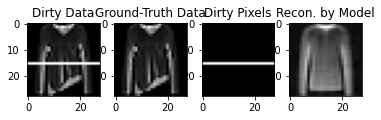

y_noise: 1


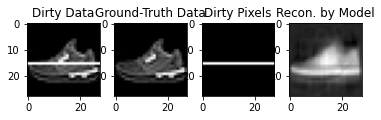

y_noise: 1


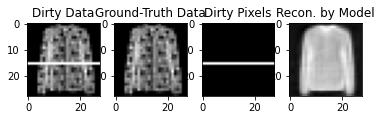

y_noise: 1


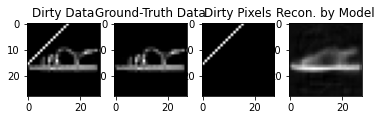

y_noise: 1


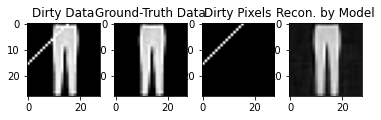

y_noise: 1


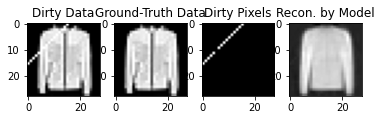

y_noise: 1


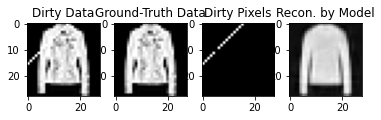

y_noise: 1


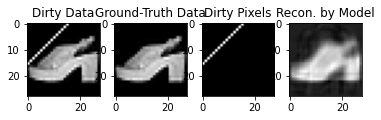

y_noise: 1


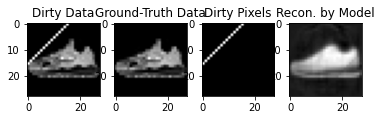

y_noise: 1


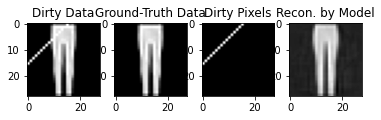

y_noise: 1


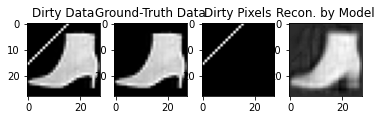

y_noise: 1


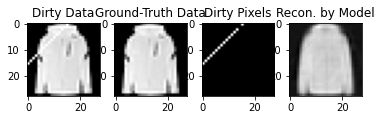

y_noise: 1


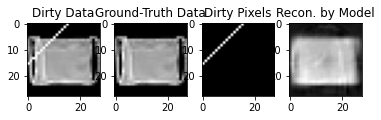

y_noise: 1


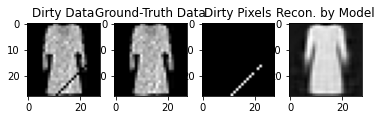

y_noise: 1


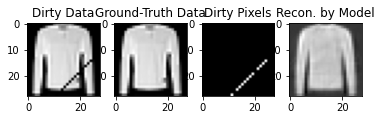

y_noise: 1


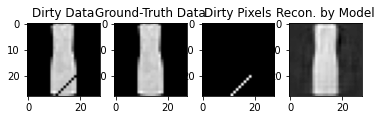

y_noise: 1


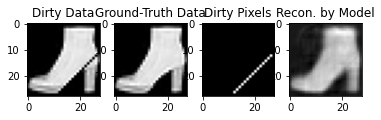

y_noise: 1


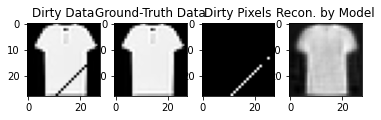

y_noise: 1


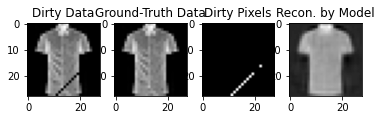

y_noise: 1


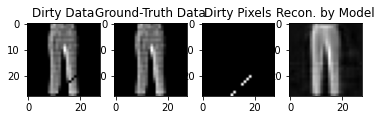

y_noise: 1


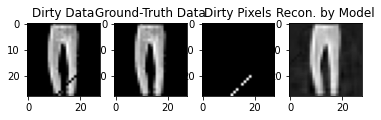

y_noise: 1


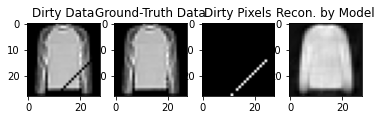

y_noise: 1


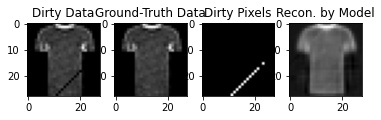

In [40]:
    
for idx in trusted_idxs_train:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray")
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Latent Space

In [41]:
noised_rows = y_noise_instance_train
noised_rows_str = ["Inlier" if not row_val else "Outlier" for row_val in noised_rows]

#### PCA

In [42]:
from sklearn.decomposition import PCA

all_z_train = np.concatenate([z_train_clean,z_train_dirty], axis=0)
pca_2d_z = PCA(n_components=2) # PCA
pca_2d_z.fit(all_z_train)

PCA(n_components=2)

In [43]:
pca_2d_z.explained_variance_

array([46.92567987,  0.66279672])

In [44]:
z_train_pca2d_clean = pca_2d_z.transform(z_train_clean)
z_train_pca2d_dirty = pca_2d_z.transform(z_train_dirty)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D): for q(z|x,y=1)')

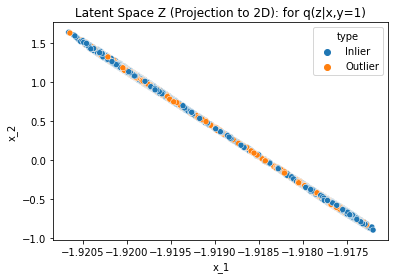

In [45]:
df_plot_z_pca2d_y1 = pd.DataFrame({"x_1": z_train_pca2d_clean[:,0], 
                                   "x_2": z_train_pca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_pca2d_y1)
plt.title("Latent Space Z (Projection to 2D): for q(z|x,y=1)")

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D): for q(z|x,y=0)')

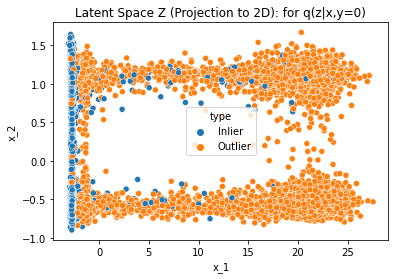

In [46]:
df_plot_z_pca2d_y0 = pd.DataFrame({"x_1": z_train_pca2d_dirty[:,0], 
                                   "x_2": z_train_pca2d_dirty[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_pca2d_y0)
plt.title("Latent Space Z (Projection to 2D): for q(z|x,y=0)")

### Kernel PCA

In [47]:
# from sklearn.decomposition import KernelPCA

# kpca_2d_z = KernelPCA(n_components=2, kernel='rbf', degree=5)
# kpca_2d_z.fit(all_z_train)

In [48]:
# z_train_kpca2d_clean = kpca_2d_z.transform(z_train_clean)
# z_train_kpca2d_dirty = kpca_2d_z.transform(z_train_dirty)

In [49]:
# df_plot_z_kpca2d_y1 = pd.DataFrame({"x_1": z_train_kpca2d_clean[:,0], 
#                                     "x_2": z_train_kpca2d_clean[:,1], 
#                                     "type": noised_rows_str})
# sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_kpca2d_y1)
# plt.title("Latent Space Z (Projection to 2D): for q(z|x,y=1)")

In [50]:
# df_plot_z_kpca2d_y0 = pd.DataFrame({"x_1": z_train_kpca2d_dirty[:,0], 
#                                     "x_2": z_train_kpca2d_dirty[:,1], 
#                                     "type": noised_rows_str})
# sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_kpca2d_y0)
# plt.title("Latent Space Z (Projection to 2D): for q(z|x,y=0)")

#### T-SNE

In [51]:
# from sklearn.manifold import TSNE

In [52]:
# tsne_2d_z = TSNE(n_components=2, perplexity=180.0, n_iter=5000)
# _z_all_2d = tsne_2d_z.fit_transform(all_z_train)

In [53]:
# _len_dataset = z_train_pca2d_clean.shape[0]

# z_train_tsne2d_clean = _z_all_2d[:_len_dataset]
# z_train_tsne2d_dirty = _z_all_2d[_len_dataset:]

In [54]:
# df_plot_z_tsne2d_y1 = pd.DataFrame({"x_1": z_train_tsne2d_clean[:,0], 
#                                    "x_2": z_train_tsne2d_clean[:,1], 
#                                    "type": noised_rows_str})
# sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_tsne2d_y1)
# plt.title("Latent Space Z (Projection to 2D): for q(z|x,y=1)")

In [55]:
# df_plot_z_tsne2d_y0 = pd.DataFrame({"x_1": z_train_tsne2d_dirty[:,0], 
#                                    "x_2": z_train_tsne2d_dirty[:,1], 
#                                    "type": noised_rows_str})
# sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_tsne2d_y0)
# plt.title("Latent Space Z (Projection to 2D): for q(z|x,y=0)")

### Approx. Log-Likelihood

In [56]:
from repair_syserr_models.loss_utils import log_px_approx_eval

In [57]:
# TODO: insert option for cuda vs. cpu !!
x_inputs = X_train.cuda()
vae_mdl.cuda();


In [58]:
with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True) as prof:

    # log p(x|y) evaluation, for both y=1 and y=0
    elbo_iwae_map = log_px_approx_eval(vae_mdl,
                                       dataset_obj,
                                       x_inputs,
                                       k_samples=250,
                                       y_comps=True,
                                       batch_size=128)

    # to clear GPU Mem -- if used.
    log_px_est_y1 = elbo_iwae_map["y1"].clone().cpu()
    log_px_est_y0 = elbo_iwae_map["y0"].clone().cpu()
    
    del elbo_iwae_map["y1"]
    del elbo_iwae_map["y0"]
    del elbo_iwae_map
    torch.cuda.empty_cache()


Compute Progress: 100%|███████████████████████████████████████████| 422/422 [00:10<00:00, 41.42it/s]


In [59]:
# print(prof)

In [60]:
arrs_elbo_iwae = np.concatenate([log_px_est_y1,log_px_est_y0,y_noise_instance_train.reshape(-1,1)], axis=1)

df_elbo_iwae = pd.DataFrame(arrs_elbo_iwae, columns=["log_px_y1", "log_px_y0", "noise_label"])
df_elbo_iwae["noise_label"] = df_elbo_iwae["noise_label"].apply(lambda x: "dirty" if x==1 else "clean")

In [61]:
df_elbo_iwae

log_px_y1   log_px_y0 noise_label
0      457.521912  446.538605       clean
1      446.619690  431.275482       clean
2     -351.110046  145.036377       dirty
3      451.787506  431.837921       clean
4      679.169434  665.325195       clean
...           ...         ...         ...
53995  378.971375  364.725739       clean
53996    7.384703   -2.698843       clean
53997  633.755432  619.033264       clean
53998  533.312927  518.467529       clean
53999  590.742126  578.832764       clean

[54000 rows x 3 columns]

In [62]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

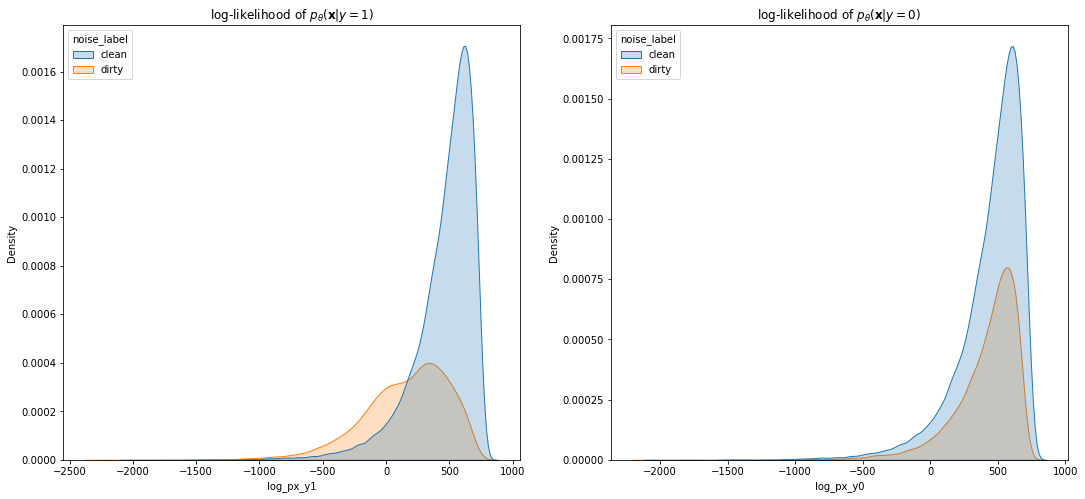

In [63]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.kdeplot(ax=axes[0], data=df_elbo_iwae, x="log_px_y1", hue="noise_label", fill=True, legend=True)

axes[0].set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=1)$")
move_legend(axes[0], "upper left")


sns.kdeplot(ax=axes[1], data=df_elbo_iwae, x="log_px_y0", hue="noise_label", fill=True, legend=True)

axes[1].set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=0)$")
move_legend(axes[1], "upper left")


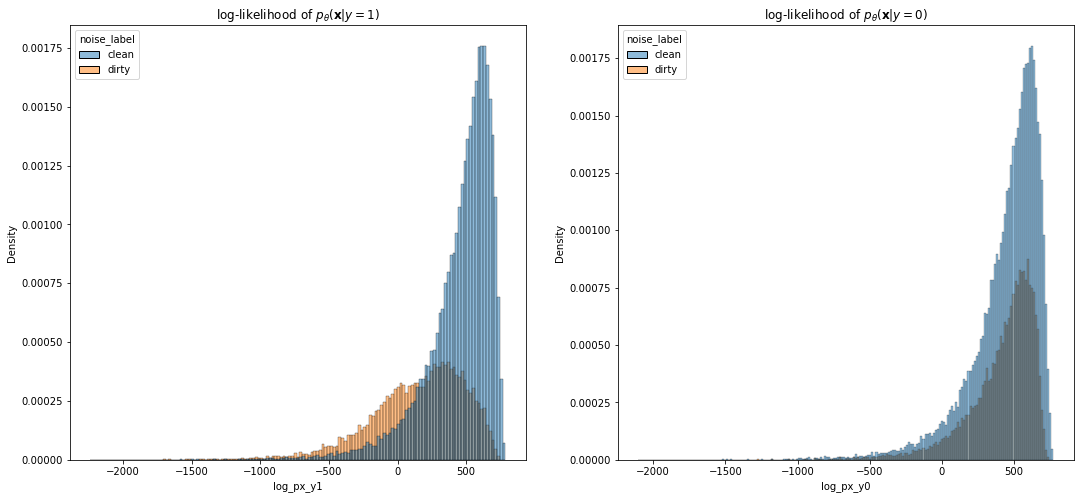

In [64]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

sns.histplot(ax=axes[0], data=df_elbo_iwae, x="log_px_y1", hue="noise_label", legend=True, stat="density")
axes[0].set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=1)$")
move_legend(axes[0], "upper left")

sns.histplot(ax=axes[1], data=df_elbo_iwae, x="log_px_y0", hue="noise_label", legend=True, stat="density")
axes[1].set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=0)$")
move_legend(axes[1], "upper left")


In [65]:
def epdf(xs, bins):
    xmin, xmax = np.inf, -np.inf
    for xi in xs:
        xmin = min(xmin, np.nanmin(xi))
        xmax = max(xmax, np.nanmax(xi))
    bin_range = (xmin, xmax)
    bins = np.lib.histograms.histogram_bin_edges(np.concatenate(xs), bins, bin_range)
    tops = []
    for xi in xs:
        m, _ = np.histogram(xi, bins, density=True)
        tops.append(m.astype(float))
    return tops, bins


In [66]:
tops, bin_edges = epdf([log_px_est_y1.numpy().flatten()[~y_noise_instance_train], log_px_est_y1.numpy().flatten()[y_noise_instance_train]], 25)
top_model, top_data = tops[0], tops[1]

In [67]:
np.sum(np.abs(top_model - top_data))

0.0072053585921788305

In [68]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

In [69]:
histogram_intersection(tops[0], tops[1], bin_edges)

0.564151355704962